 This notebook uses a vanilla (basic) Bayesian optimization algorithm to tackle an urban travel demand (i.e.,  origin-destination, OD) calibration problem. The traffic simulations are based on the SUMO simulator. It considers a toy network, called quickstart detailed here:
 https://sumo.dlr.de/docs/Tutorials/quick_start.html

# Install sumo

In [1]:
import importlib
import helpers_od_calibration_BN
importlib.reload(helpers_od_calibration_BN)

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'helpers_od_calibration_BN' from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/helpers_od_calibration_BN.py'>

Mount GDrive

If you are working w/ colab rather than a jupyterlab notebook this drive mounting and sumo installation will need to be done every time you restart the runtime.


In [ ]:
import os
from pathlib import Path 
import sys
import json, shutil

os.environ['SUMO_HOME'] = '/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo'
os.environ['LIBSUMO_AS_TRACI'] = '1' #Optional: for a huge performance boost (~8x) with Libsumo (No GUI)
SUMO_HOME = Path(os.environ['SUMO_HOME'])

if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")
#import traci



# Add the SUMO *bin* directory to PATH so od2trips/duarouter/sumo are found
# Your SUMO_HOME is .../EclipseSUMO/share/sumo → bin is two levels up, then /bin
SUMO_ROOT = Path(os.environ["SUMO_HOME"]).parents[1]          # .../EclipseSUMO
SUMO_BIN  = str(SUMO_ROOT / "bin") # this convert path to /EclipseSUMO/bin
LIB_SUMO_PATH = Path(os.environ["SUMO_HOME"]).parents[2] / "lib" / "libsumo.dylib"

os.environ["PATH"] = SUMO_BIN + os.pathsep + os.environ.get("PATH", "")

import traci
import sumolib


base_path = '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn'
# if base_path has a space in it, the sumo code will not work
if ' ' in base_path:
    raise ValueError("base_path should not contain any spaces.")

os.chdir(base_path)



import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import seaborn as sns
from pathlib import Path

import torch
from torch.quasirandom import SobolEngine

from botorch import fit_gpytorch_mll
from botorch.acquisition import qLogExpectedImprovement
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from botorch.optim import optimize_acqf
from botorch.sampling.stochastic_samplers import StochasticSampler
from botorch.utils.transforms import unnormalize, normalize

from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.transforms.outcome import Standardize



from helpers_od_calibration_BN import (load_kwargs_config,
                    compute_nrmse_counts_all_edges,
                    parse_loop_data_xml_to_pandas,
                    create_taz_xml,
                    simulate_od,
                    od_xml_to_df,
                    compute_nrmse_counts_all_edges,
                    )

%matplotlib inline


config = load_kwargs_config(
    base_path,
    "bo_vanilla",
    sim_setup_filename="sim_setup_network_2corridor.json"
)
Path(config["simulation_run_path"]).mkdir(parents=True, exist_ok=True)
pprint.pprint(dict(config))

{'BATCH_SIZE': 1,
 'EDGE_OUT_STR': 'edge_data.xml',
 'NITER': 100,
 'NUM_RESTARTS': 16,
 'RAW_SAMPLES': 256,
 'SAMPLE_SHAPE': 64,
 'SUMO_PATH': PosixPath('/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo'),
 'TRIPS2ODS_OUT_STR': 'trips.xml',
 'additional_xml': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml'),
 'file_gt_od': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/od.xml'),
 'fixed_routes': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/routes_single.csv'),
 'model_name': 'bo_vanilla',
 'n_init_search': 20,
 'net_xml': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml'),
 'network_name': 'network_2corridor',
 'network_path': PosixPath('network/network_2corridor'),
 'od_duration_sec': 3600,
 'sim_end_time': 3900,
 'sim_start_time': 0,
 'sim_stat_freq_sec': 300,
 'simul

/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo/tools/traci/__init__.py:42: UserWarning: Could not import libsumo using /Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/bin/python, falling back to pure python traci (No module named 'libsumo').
  warnings.warn("Could not import libsumo using %s, falling back to pure python traci (%s)." %


Install SUMO

Set sumo env vars

# Create GT (ground truth) scenario

In [3]:
# Get Ground Truth OD + fixed routes
print(f"Reading: {config['file_gt_od']}")
gt_od_df = od_xml_to_df(config["file_gt_od"])

print(f"Reading: {config['fixed_routes']}")
routes_df = pd.read_csv(config["fixed_routes"], index_col=0)

Reading: /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/od.xml
Total GT demand: 23261.0
Reading: /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/routes_single.csv


In [4]:
#import os
#print(os.listdir("output/network_2corridor_bo_vanilla/ground_truth"))

Simulate the GT scenario to obtain the GT traffic statistics

In [5]:
simulation_gt_run_path = f"{config['simulation_run_path']}/ground_truth"
prefix_output_gt = f"{simulation_gt_run_path}/sim"
sim_edge_out_gt = f"{prefix_output_gt}_{config['EDGE_OUT_STR']}"
new_od_xml = f"{simulation_gt_run_path}/od.xml"

Path(simulation_gt_run_path).mkdir(parents=True, exist_ok=True)

base_od = gt_od_df.copy()
curr_od = base_od['count'].astype(float).to_numpy()
base_od['count'] = curr_od
base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})

create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path)

simulate_od(
    new_od_xml,
    prefix_output_gt,
    base_path,
    config["net_xml"],
    config["taz2edge_xml"],
    config["additional_xml"],
    routes_df,
    config["sim_end_time"],
    config["TRIPS2ODS_OUT_STR"]
)

Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/ground_truth/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/ground_truth/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/ground_truth/sim_trips_beforeRteUpdates.xml
Success.time 3598.89ing time 946.50 1844.369.98
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/ground_truth/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/ground_truth/sim_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-vali

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (5ms ~= 200.00*RT, ~252600.00UPS, vehicles TOT 12105 ACT 1263 BUF 11156)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 8.21s
 Real time factor: 474.973
 UPS: 589394.714408
Vehicles:
 Inserted: 12105 (Loaded: 23261)
 Running: 1263
 Waiting: 11156
Statistics (avg of 10842):
 RouteLength: 3400.06
 Speed: 13.97
 Duration: 353.52
 WaitingTime: 1.51
 TimeLoss: 208.99
 DepartDelay: 295.38
DijkstraRouter answered 28380 queries and explored 22.41 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).


In [6]:
sim_edge_out_gt = f"{prefix_output_gt}_{config['EDGE_OUT_STR']}"
print(sim_edge_out_gt)

output/network_2corridor_bo_vanilla/ground_truth/sim_edge_data.xml


In [7]:
import os
print(os.listdir("output/network_2corridor_bo_vanilla/ground_truth"))

['sim_loopOutputs.csv', 'sim_edge_data.xml', 'sim_routes.vehroutes.xml', 'od.xml', 'sim_trips.xml', 'sim_trips_beforeRteUpdates.xml']


Read and process the GT simulation outputs

In [8]:
df_edge_gt, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out_gt, prefix_output_gt, config["SUMO_PATH"])
# picking at edges as GT edges
num_gt_edges = df_edge_gt.shape[0]
print("Number of GT edges:",num_gt_edges)
gt_edge_data = df_edge_gt\
    .sort_values(by=['interval_nVehContrib'], ascending=False)\
    .iloc[:num_gt_edges]

print(sim_edge_out_gt)

Number of GT edges: 51
output/network_2corridor_bo_vanilla/ground_truth/sim_edge_data.xml


# Optimization

Vanilla Bayesian Optimization (BO)


Bayesian optimization utils / helpers

In [9]:
from botorch.optim import optimize_acqf

def initialize_gp_model(train_X, train_Y):
    dim = train_X.size(dim=1)

    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    covar_module = ScaleKernel(
        MaternKernel(
            nu=2.5,
            ard_num_dims=dim,
            lengthscale_constraint=Interval(0.005, 4.0),
        )
    )

    gp_model = SingleTaskGP(
        train_X,
        train_Y,
        covar_module=covar_module,
        likelihood=likelihood,
        outcome_transform=Standardize(m=1),
    )

    gp_mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    return gp_model, gp_mll


def optimize_acqf_and_get_observation(
    acq_func,
    bounds,         # here: NORMALIZED bounds, e.g. bounds_norm in [0,1]^dim
    device,
    dtype,
    BATCH_SIZE,
    NUM_RESTARTS,
    RAW_SAMPLES,
):
    """
    Optimizes the acquisition function and returns a new candidate in the
    SAME space as `bounds` (here: normalized OD space).
    """

    dim = acq_func.model.train_inputs[0].size(dim=1)

    candidates, _ = optimize_acqf(
        acq_function=acq_func,      # EI over normalized OD space
        bounds=bounds,              # <--- use the given bounds (e.g. bounds_norm)
        q=1,               # 1 = standard sequential BO
        num_restarts=NUM_RESTARTS,  # multistart optimization
        raw_samples=RAW_SAMPLES,    # Sobol init points for EI
        # options={"batch_limit": 5, "maxiter": 200},  # optional
    )

    new_x = candidates.detach()
    return new_x

Declare parameter space


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.double

dim_od = gt_od_df.shape[0]
print(dim_od)

bounds = torch.tensor([
    [ 0 for _ in range(dim_od)],
    [ 2000 for _ in range(dim_od)]
], device=device, dtype=dtype)

cpu
21


## Create and simulate a sample of initial input points (i.e., ODs).

In [11]:
# Sample according to Sobol, drawn are quasi random so need multiple restart !! 
# quasi bc they cover the aparameters space more evenly than pure randomness, they avoid lcuster and gaps so better coverage of space 
#it ensure we can explore differnt regions 
#better initial data, bette gp, better optimization 

seed = 42  

torch.manual_seed(seed)

np.random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

print(f"Random seed set to {seed}")



sobol = SobolEngine(dim_od, scramble=True, seed = seed) #Sobol sequences are an example of low discrepancy quasi-random sequences.
#using seed for reproducibility
x_0 = sobol.draw(config["n_init_search"]).to(dtype=dtype).to(device) # generate n_init_search samples, here 5
print (x_0.shape)
#x_0 shape: torch.Size([5, 4]) meaning 5 samples of 4 dimensions each
# map the normalized into the original parameter space
train_X0 = unnormalize(x_0, bounds)
print (train_X0)  #5 samples of 4 dimensions each


print (dim_od)
#4 dimension, 4OD pairs
#so we have 4 pairs so 4 demand values to optimize

Random seed set to 42
torch.Size([20, 21])
tensor([[1995.0267,  208.7328, 1645.9577,  838.8643, 1056.6442,  112.4814,
          910.5846, 1498.4061,  442.1483, 1235.3967, 1620.1895,  424.5811,
           76.8722, 1763.6480, 1301.2593, 1333.1703, 1641.8632, 1193.1571,
          472.6151, 1613.9487,  334.2874],
        [  57.3551, 1496.5136,  224.1529, 1034.3661,   68.6411, 1638.0646,
         1126.1221,  371.2380, 1489.2815,  275.1244,  427.1543, 1754.9608,
         1361.3771,  688.0627,  422.7808,  381.8277,  870.4802,  384.3589,
         1190.8222,  718.8758, 1254.2589],
        [ 802.7174,  560.0206, 1008.2554,  332.2719,  831.8899, 1257.5989,
          222.3803,  637.7038, 1993.9388,  556.7673,  973.7991, 1018.7044,
          889.5292, 1128.8687,  831.6194, 1833.3936,  423.0999, 1505.8671,
         1656.2229, 1015.0840,  790.3093],
        [1239.9006, 1770.1647,  617.7125, 1544.8638, 1796.4624,  993.6885,
         1944.2205, 1515.1131,  945.3723, 1955.6307, 1042.3532,  661.0953,
   

In [12]:
ods_epsilon = []
loss_all = []
batch_data_i = []

base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()

for i , x in enumerate(train_X0.tolist()):
      print(f"########### OD: {i} ###########")
      print(x)

      simulation_run_path_init =f'{config["simulation_run_path"]}/initial_search'
      Path(simulation_run_path_init).mkdir(parents=True, exist_ok=True)

      new_od_xml = f"{simulation_run_path_init}/gt_od_{config['network_name']}_{i}.xml"
      prefix_output_init = f'{simulation_run_path_init}/sobol_{i}'

      # Generate OD
      #curr_od = gt_od_vals.copy()
      curr_od = np.array(x)

      print(f'total expected GT demand: {np.sum(curr_od)}')

      ###
      # create OD xml file
      ###
      base_od['count'] = curr_od
      # round to 1 decimal point
      base_od['count'] = [round(elem, 1) for elem in base_od['count']]
      base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})
      create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path)
      ods_epsilon.append(curr_od)

      # simulate initial sample
      simulate_od(new_od_xml,
                  prefix_output_init,
                  base_path,
                  config["net_xml"],
                  config["taz2edge_xml"],
                  config["additional_xml"],
                  routes_df,
                  config["sim_end_time"],
                  config["TRIPS2ODS_OUT_STR"])

      ## Compute loss
      #prefix_output = f'initial_search/sobol_{i}'
      sim_edge_out = f'{base_path}/{prefix_output_init}_{config["EDGE_OUT_STR"]}'
      print(sim_edge_out)
      curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out,prefix_output_init,config["SUMO_PATH"])
      curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_loop_stats)

      loss_all.append(curr_loss)
      print(f"############## loss: {curr_loss} ##############")

      # Parse training data
      df_curr = pd.DataFrame(curr_od.reshape(1,dim_od),
                        columns = [f"x_{i+1}" for i in range(dim_od)])
      df_curr['loss'] = curr_loss
      batch_data_i.append(df_curr)

df_initial_bo = pd.concat(batch_data_i)
# Save initial dataset
df_initial_bo.to_csv(f"{config['simulation_run_path']}/initial_search/data_set_ods_0_2000.csv",index=None)
print(f"save df_initial_bo at {config['simulation_run_path']}/initial_search/data_set_ods_0_2000.csv")


########### OD: 0 ###########
[1995.026707649231, 208.73278379440308, 1645.9577083587646, 838.8643264770508, 1056.6442012786865, 112.48141527175903, 910.584568977356, 1498.4060525894165, 442.14826822280884, 1235.3967428207397, 1620.1895475387573, 424.5811402797699, 76.87224447727203, 1763.6480331420898, 1301.2592792510986, 1333.1702947616577, 1641.863226890564, 1193.1570768356323, 472.6150929927826, 1613.9487028121948, 334.2874348163605]
total expected GT demand: 21719.834849238396
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/gt_od_network_2corridor_0.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/initial_search/gt_od_network_2corridor_0.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_0_trips_beforeRteUpdates.xml


pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (5ms ~= 200.00*RT, ~219600.00UPS, vehicles TOT 11188 ACT 1098 BUF 10531)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 7.66s
 Real time factor: 508.873
 UPS: 638899.399791
Vehicles:
 Inserted: 11188 (Loaded: 21719)
 Running: 1098
 Waiting: 10531
Statistics (avg of 10090):
 RouteLength: 4183.02
 Speed: 12.94
 Duration: 411.34
 WaitingTime: 2.23
 TimeLoss: 242.68
 DepartDelay: 335.61
DijkstraRouter answered 26051 queries and explored 24.07 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_0_edge_data.xml
############## loss: 0.1282607298725388 ##############
########### OD: 1 ###########
[57.35509470105171, 1496.5136051177979, 224.15287792682648, 1034.3661308288574, 68.64109635353088, 1638.0646228790283, 1126.1221170425415, 371.23799324035645, 1489.2815351486206, 275

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~782500.00UPS, vehicles TOT 11555 ACT 1565 BUF 5682)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 3.20s
 Real time factor: 1218.75
 UPS: 1567990.312500
Vehicles:
 Inserted: 11555 (Loaded: 17237)
 Running: 1565
 Waiting: 5682
Statistics (avg of 9990):
 RouteLength: 3301.21
 Speed: 12.76
 Duration: 386.21
 WaitingTime: 1.30
 TimeLoss: 245.82
 DepartDelay: 281.26
DijkstraRouter answered 21539 queries and explored 22.59 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_1_edge_data.xml
############## loss: 0.6257545846478675 ##############
########### OD: 2 ###########
[802.717387676239, 560.0206255912781, 1008.2553625106812, 332.271933555603, 831.8898677825928, 1257.598876953125, 222.38034009933472, 637.7037763595581, 1993.9388036727905, 556.767284

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~628666.67UPS, vehicles TOT 10901 ACT 1886 BUF 9371)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.79s
 Real time factor: 673.11
 UPS: 1068088.712461
Vehicles:
 Inserted: 10901 (Loaded: 20272)
 Running: 1886
 Waiting: 9371
Statistics (avg of 9015):
 RouteLength: 3729.93
 Speed: 12.29
 Duration: 521.32
 WaitingTime: 1.83
 TimeLoss: 365.96
 DepartDelay: 317.48
DijkstraRouter answered 25049 queries and explored 22.19 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_2_edge_data.xml
############## loss: 0.4672818001852269 ##############
########### OD: 3 ###########
[1239.9005889892578, 1770.1647281646729, 617.7124977111816, 1544.8638200759888, 1796.4624166488647, 993.6885237693787, 1944.2205429077148, 1515.113115310669, 945.3722834587097, 1955.63

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~1461000.00UPS, vehicles TOT 14213 ACT 1461 BUF 11528)  
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 9.01s
 Real time factor: 432.708
 UPS: 595791.190503
Vehicles:
 Inserted: 14213 (Loaded: 25741)
 Running: 1461
 Waiting: 11528
Statistics (avg of 12752):
 RouteLength: 3614.68
 Speed: 13.67
 Duration: 350.36
 WaitingTime: 1.54
 TimeLoss: 202.22
 DepartDelay: 267.40
DijkstraRouter answered 32266 queries and explored 24.38 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_3_edge_data.xml
############## loss: 0.3468817324293372 ##############
########### OD: 4 ###########
[1268.8524723052979, 988.6295795440674, 330.61590790748596, 1852.891445159912, 1670.6719398498535, 363.4827435016632, 354.1649580001831, 933.4617257118225, 1562.9404783248901, 169.06

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~1457000.00UPS, vehicles TOT 11690 ACT 1457 BUF 9189)   
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.29s
 Real time factor: 620.229
 UPS: 838904.103053
Vehicles:
 Inserted: 11690 (Loaded: 20879)
 Running: 1457
 Waiting: 9189
Statistics (avg of 10233):
 RouteLength: 3797.06
 Speed: 10.65
 Duration: 454.50
 WaitingTime: 2.38
 TimeLoss: 298.85
 DepartDelay: 373.62
DijkstraRouter answered 26923 queries and explored 22.46 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_4_edge_data.xml
############## loss: 0.2540341371205709 ##############
########### OD: 5 ###########
[706.1657309532166, 1716.3516283035278, 1783.635139465332, 16.187692061066628, 705.6182622909546, 1885.2322101593018, 1578.1110525131226, 1806.2996864318848, 611.0526323318481, 1317.9

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (6ms ~= 166.67*RT, ~487500.00UPS, vehicles TOT 12478 ACT 2925 BUF 12554)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 11.58s
 Real time factor: 336.729
 UPS: 691701.864963
Vehicles:
 Inserted: 12478 (Loaded: 25032)
 Running: 2925
 Waiting: 12554
Statistics (avg of 9553):
 RouteLength: 3055.83
 Speed: 11.14
 Duration: 518.22
 WaitingTime: 1.99
 TimeLoss: 387.89
 DepartDelay: 236.94
DijkstraRouter answered 30066 queries and explored 22.36 edges on average.
DijkstraRouter spent 0.07s answering queries (0.00ms on average).
/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_5_edge_data.xml
############## loss: 0.5257784564761453 ##############
########### OD: 6 ###########
[465.20179510116577, 277.90573239326477, 952.6864886283875, 1351.1828184127808, 444.45282220840454, 1000.8448362350464, 544.3642735481262, 1195.806384086609, 122.53917008638382, 1599

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~2869000.00UPS, vehicles TOT 10764 ACT 2869 BUF 4238)   
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 4.00s
 Real time factor: 975.732
 UPS: 1427379.534651
Vehicles:
 Inserted: 10764 (Loaded: 15002)
 Running: 2869
 Waiting: 4238
Statistics (avg of 7895):
 RouteLength: 3487.14
 Speed: 15.32
 Duration: 332.90
 WaitingTime: 0.78
 TimeLoss: 184.81
 DepartDelay: 229.43
DijkstraRouter answered 17764 queries and explored 24.38 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_6_edge_data.xml
############## loss: 0.13550189665760726 ##############
########### OD: 7 ###########
[1527.4003744125366, 1052.0144701004028, 1436.9534254074097, 529.6159982681274, 1432.9513311386108, 748.6113905906677, 1258.040428161621, 73.22125136852264, 1074.9448537826538, 889.3

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~515000.00UPS, vehicles TOT 13121 ACT 1545 BUF 8446)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.08s
 Real time factor: 768.17
 UPS: 1155703.959031
Vehicles:
 Inserted: 13121 (Loaded: 21567)
 Running: 1545
 Waiting: 8446
Statistics (avg of 11576):
 RouteLength: 3644.05
 Speed: 13.62
 Duration: 408.56
 WaitingTime: 1.82
 TimeLoss: 259.58
 DepartDelay: 150.69
DijkstraRouter answered 26058 queries and explored 23.24 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_7_edge_data.xml
############## loss: 0.1490591174235279 ##############
########### OD: 8 ###########
[1730.8591604232788, 683.4856867790222, 811.2554550170898, 199.19121265411377, 181.64664506912231, 819.477379322052, 441.3764178752899, 758.7960958480835, 1748.1902837753296, 1828.399

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~1422000.00UPS, vehicles TOT 10552 ACT 1422 BUF 7240)   
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 4.68s
 Real time factor: 833.868
 UPS: 1039317.297413
Vehicles:
 Inserted: 10552 (Loaded: 17792)
 Running: 1422
 Waiting: 7240
Statistics (avg of 9130):
 RouteLength: 3951.87
 Speed: 13.29
 Duration: 439.75
 WaitingTime: 1.61
 TimeLoss: 277.31
 DepartDelay: 328.92
DijkstraRouter answered 22520 queries and explored 21.81 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_8_edge_data.xml
############## loss: 1.0675881618031076 ##############
########### OD: 9 ###########
[293.1721806526184, 1892.7754163742065, 1326.431393623352, 1924.038290977478, 1193.636417388916, 1431.0743808746338, 1725.2740859985352, 1886.2080574035645, 703.0073404312134, 680.626

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (7ms ~= 142.86*RT, ~328000.00UPS, vehicles TOT 13677 ACT 2296 BUF 13325)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 10.21s
 Real time factor: 382.016
 UPS: 681369.379959
Vehicles:
 Inserted: 13677 (Loaded: 27002)
 Running: 2296
 Waiting: 13325
Statistics (avg of 11381):
 RouteLength: 3289.87
 Speed: 12.32
 Duration: 469.15
 WaitingTime: 1.85
 TimeLoss: 331.40
 DepartDelay: 247.68
DijkstraRouter answered 32897 queries and explored 23.48 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_9_edge_data.xml
############## loss: 0.9295962081554157 ##############
########### OD: 10 ###########
[534.6282124519348, 81.2213122844696, 409.88269448280334, 692.6000118255615, 1956.8923711776733, 1550.5856275558472, 629.1495561599731, 1119.498372077942, 190.59766829013824, 401.7

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~1196333.33UPS, vehicles TOT 8344 ACT 3589 BUF 9421)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 4.11s
 Real time factor: 948.674
 UPS: 2478540.257845
Vehicles:
 Inserted: 8344 (Loaded: 17765)
 Running: 3589
 Waiting: 9421
Statistics (avg of 4755):
 RouteLength: 2813.62
 Speed: 10.62
 Duration: 436.30
 WaitingTime: 0.91
 TimeLoss: 305.27
 DepartDelay: 109.20
DijkstraRouter answered 21219 queries and explored 23.35 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_10_edge_data.xml
############## loss: 0.23224930990445264 ##############
########### OD: 11 ###########
[1471.8270301818848, 1370.1008558273315, 1956.3214778900146, 1434.5366954803467, 921.4577674865723, 200.6921023130417, 1407.6296091079712, 242.33339726924896, 1237.2158765792847, 11

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~647500.00UPS, vehicles TOT 14660 ACT 1295 BUF 7052)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 4.91s
 Real time factor: 794.297
 UPS: 1082010.183299
Vehicles:
 Inserted: 14660 (Loaded: 21712)
 Running: 1295
 Waiting: 7052
Statistics (avg of 13365):
 RouteLength: 3391.59
 Speed: 14.61
 Duration: 329.61
 WaitingTime: 1.45
 TimeLoss: 189.42
 DepartDelay: 168.06
DijkstraRouter answered 26475 queries and explored 23.04 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_11_edge_data.xml
############## loss: 0.21615944503828463 ##############
########### OD: 12 ###########
[1005.6154727935791, 400.4172086715698, 1243.4107065200806, 1242.5371408462524, 545.676589012146, 562.7425312995911, 762.8262639045715, 1324.7169256210327, 369.7067201137543, 762.

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~2910000.00UPS, vehicles TOT 9788 ACT 2910 BUF 8662)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 3.33s
 Real time factor: 1170.82
 UPS: 2478759.231462
Vehicles:
 Inserted: 9788 (Loaded: 18450)
 Running: 2910
 Waiting: 8662
Statistics (avg of 6878):
 RouteLength: 2960.89
 Speed: 14.20
 Duration: 440.50
 WaitingTime: 0.93
 TimeLoss: 308.82
 DepartDelay: 125.75
DijkstraRouter answered 22897 queries and explored 21.50 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_12_edge_data.xml
############## loss: 0.33004537408594015 ##############
########### OD: 13 ###########
[942.9436326026917, 1175.6246089935303, 634.510338306427, 876.5429258346558, 1580.615758895874, 1185.9782934188843, 1039.505958557129, 452.12337374687195, 1323.5505819320679, 1723.5

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~898500.00UPS, vehicles TOT 12287 ACT 1797 BUF 7967)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 4.62s
 Real time factor: 844.521
 UPS: 1339555.218709
Vehicles:
 Inserted: 12287 (Loaded: 20254)
 Running: 1797
 Waiting: 7967
Statistics (avg of 10490):
 RouteLength: 3810.10
 Speed: 11.71
 Duration: 487.89
 WaitingTime: 2.58
 TimeLoss: 332.25
 DepartDelay: 179.94
DijkstraRouter answered 25385 queries and explored 25.55 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_13_edge_data.xml
############## loss: 0.17213438347078902 ##############
########### OD: 14 ###########
[198.07344675064087, 862.1176481246948, 1597.9056358337402, 1740.8277988433838, 1319.4574117660522, 1801.5985488891602, 73.1419026851654, 562.3723864555359, 1819.9385404586792, 14

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (4ms ~= 250.00*RT, ~709250.00UPS, vehicles TOT 11802 ACT 2837 BUF 16188)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 9.66s
 Real time factor: 403.601
 UPS: 826964.089827
Vehicles:
 Inserted: 11802 (Loaded: 27990)
 Running: 2837
 Waiting: 16188
Statistics (avg of 8965):
 RouteLength: 3063.99
 Speed: 11.29
 Duration: 453.54
 WaitingTime: 1.62
 TimeLoss: 321.29
 DepartDelay: 269.69
DijkstraRouter answered 34824 queries and explored 21.23 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_14_edge_data.xml
############## loss: 0.10113846117923729 ##############
########### OD: 15 ###########
[1760.2568864822388, 1588.9852046966553, 20.251857116818428, 389.9700939655304, 307.9487681388855, 447.84826040267944, 1859.0844869613647, 1685.2014064788818, 865.5750155448914, 46

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~543000.00UPS, vehicles TOT 12310 ACT 1086 BUF 5578)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 4.35s
 Real time factor: 897.17
 UPS: 999753.853232
Vehicles:
 Inserted: 12310 (Loaded: 17888)
 Running: 1086
 Waiting: 5578
Statistics (avg of 11224):
 RouteLength: 3658.61
 Speed: 14.72
 Duration: 337.68
 WaitingTime: 1.03
 TimeLoss: 186.63
 DepartDelay: 181.03
DijkstraRouter answered 20422 queries and explored 23.03 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_15_edge_data.xml
############## loss: 1.1240263237165022 ##############
########### OD: 16 ###########
[1874.9189376831055, 792.3597097396851, 1278.558373451233, 1270.2914476394653, 1864.3085956573486, 1237.064003944397, 1249.7156858444214, 607.0398092269897, 682.2496056556702, 1297.5

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (4ms ~= 250.00*RT, ~521750.00UPS, vehicles TOT 12782 ACT 2087 BUF 12618)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 8.81s
 Real time factor: 442.528
 UPS: 789513.332577
Vehicles:
 Inserted: 12782 (Loaded: 25400)
 Running: 2087
 Waiting: 12618
Statistics (avg of 10695):
 RouteLength: 4009.47
 Speed: 10.91
 Duration: 551.97
 WaitingTime: 2.46
 TimeLoss: 389.90
 DepartDelay: 353.10
DijkstraRouter answered 33361 queries and explored 25.09 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_16_edge_data.xml
############## loss: 0.2349388446027014 ##############
########### OD: 17 ###########
[187.23179399967194, 1502.6254653930664, 857.1924567222595, 606.4781546592712, 759.0499520301819, 512.2619867324829, 963.7568593025208, 1734.2536449432373, 1636.089563369751, 210.9

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~695000.00UPS, vehicles TOT 11189 ACT 695 BUF 6586)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.16s
 Real time factor: 756.107
 UPS: 595592.089957
Vehicles:
 Inserted: 11189 (Loaded: 17775)
 Running: 695
 Waiting: 6586
Statistics (avg of 10494):
 RouteLength: 3316.57
 Speed: 14.76
 Duration: 275.11
 WaitingTime: 1.04
 TimeLoss: 133.37
 DepartDelay: 424.11
DijkstraRouter answered 23447 queries and explored 21.10 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_17_edge_data.xml
############## loss: 0.6746584938161052 ##############
########### OD: 18 ###########
[922.8266477584839, 441.07189774513245, 1875.2424716949463, 1775.418758392334, 28.16510945558548, 381.01696968078613, 1930.1247596740723, 1280.0589799880981, 1132.4090957641602, 995.

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~1169000.00UPS, vehicles TOT 13545 ACT 1169 BUF 9389)   
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 10.10s
 Real time factor: 386.139
 UPS: 455790.891089
Vehicles:
 Inserted: 13545 (Loaded: 22934)
 Running: 1169
 Waiting: 9389
Statistics (avg of 12376):
 RouteLength: 3320.01
 Speed: 11.69
 Duration: 341.33
 WaitingTime: 1.35
 TimeLoss: 200.84
 DepartDelay: 371.56
DijkstraRouter answered 29652 queries and explored 22.75 edges on average.
DijkstraRouter spent 0.07s answering queries (0.00ms on average).
/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_18_edge_data.xml
############## loss: 2.7668645046582316 ##############
########### OD: 19 ###########
[1110.0252866744995, 1228.9743423461914, 485.115647315979, 97.44542837142944, 1094.354271888733, 1867.5835132598877, 153.46121788024902, 403.0616283416748, 178.0492663383484, 1518.

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~2816000.00UPS, vehicles TOT 10611 ACT 2816 BUF 7777)   
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.17s
 Real time factor: 754.498
 UPS: 1566022.634939
Vehicles:
 Inserted: 10611 (Loaded: 18388)
 Running: 2816
 Waiting: 7777
Statistics (avg of 7795):
 RouteLength: 3700.40
 Speed: 10.61
 Duration: 653.57
 WaitingTime: 2.61
 TimeLoss: 500.24
 DepartDelay: 155.44
DijkstraRouter answered 22594 queries and explored 24.68 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/initial_search/sobol_19_edge_data.xml
############## loss: 0.29093490449708204 ##############
save df_initial_bo at output/network_2corridor_bo_vanilla/initial_search/data_set_ods_0_2000.csv


In [13]:
print (base_od)
print (gt_od_vals)

      from      to   count
0    taz_0   taz_1  1110.0
1    taz_0  taz_60  1229.0
2    taz_0  taz_61   485.1
3    taz_0  taz_62    97.4
4    taz_0  taz_63  1094.4
5    taz_0  taz_64  1867.6
6   taz_60   taz_1   153.5
7   taz_60  taz_61   403.1
8   taz_60  taz_62   178.0
9   taz_60  taz_63  1518.7
10  taz_60  taz_64  1164.3
11  taz_61   taz_1   229.2
12  taz_61  taz_62   508.7
13  taz_61  taz_63  1387.8
14  taz_61  taz_64  1439.7
15  taz_62   taz_1   972.7
16  taz_62  taz_63   789.3
17  taz_62  taz_64  1640.4
18  taz_63   taz_1  1161.6
19  taz_63  taz_64   217.9
20  taz_64   taz_1   737.3
[ 148.  440.  923. 1489. 1620.  586. 1258. 1929. 1890. 1213. 1200. 1866.
 1784. 1411. 1041.  479.  528.  275. 1306. 1024.  851.]


## Run BO epochs

In [15]:
import numpy as np
import pandas as pd
import torch
import random
from pathlib import Path

from botorch.acquisition import ExpectedImprovement
from botorch.fit import fit_gpytorch_mll
from botorch.utils.transforms import normalize, unnormalize

# Define normalized bounds [0,1]^d for acquisition optimization
bounds_norm = torch.tensor(
    [[0.0] * dim_od, [1.0] * dim_od],
    device=device,
    dtype=dtype
)


seeds = [10, 55, 99, 123, 777]   
N_BO_RESTARTS = len(seeds)    

# To store trajectories across restarts
all_best_traj = []     # list of lists: best loss per iteration for each restart
all_final_best = []    # final best loss after last BO iteration for each restart


def set_global_seed(seed: int):
    """Set all relevant random seeds for reproducibility."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)




for r in range(2):

    current_seed = seeds[r]
    print("\n\n==========================")
    print(f"   BO RESTART {r+1}/{N_BO_RESTARTS}  (seed = {current_seed})")
    print("==========================\n")

    set_global_seed(current_seed)


    df_0 = pd.read_csv(
        f"{config['simulation_run_path']}/initial_search/data_set_ods_0_2000.csv"
    )

    # Per-restart training DF and best-value trajectory
    df_training = df_0.copy()
    df_training["bo_iteration"] = 0   # initial samples labeled as iteration 0

    best_value = []   # best loss after each BO iteration in this restart

    # Base OD template (we will only overwrite column "count")
    base_od_template = gt_od_df.copy()   # keep a clean copy per restart

    # ------------------------------------
    # 2. BO loop over iterations
    # ------------------------------------
    for i in range(30):
        print(f"\n########### BO iteration = {i+1} ###########")

        # ---------------------------
        # 2.1 Extract current training data
        # ---------------------------
        # X: OD vectors
        x_cols = [col for col in df_training.columns if col.startswith("x_")]
        train_X = torch.from_numpy(
            df_training[x_cols].values
        ).to(device=device, dtype=dtype)

        # Normalize to [0,1]^d with global bounds
        train_X_norm = normalize(train_X, bounds)

        # Y: scalar loss
        train_Y = torch.from_numpy(
            df_training[["loss"]].values
        ).to(device=device, dtype=dtype)

        # Current best observed loss
        best_y = train_Y.min()
        best_value.append(best_y.item())
        print(f"##### best_value so far = {best_y.item():.6f} #####")

        # ---------------------------
        # 2.2 Fit GP on current data
        # ---------------------------
        gp_model, gp_mll = initialize_gp_model(train_X_norm, train_Y)
        fit_gpytorch_mll(gp_mll)

        # ---------------------------
        # 2.3 Construct acquisition (EI)
        # ---------------------------
        EI = ExpectedImprovement(
            model=gp_model,
            best_f=best_y,
            maximize=False,
        )

        # ---------------------------
        # 2.4 Optimize acquisition to get next candidate(s)
        # ---------------------------
        x_i_norm = optimize_acqf_and_get_observation(
            acq_func=EI,
            bounds=bounds_norm,                  # [0,1]^d
            device=device,
            dtype=dtype,
            BATCH_SIZE=config["BATCH_SIZE"],     # e.g., 1 or >1
            NUM_RESTARTS=5,
            RAW_SAMPLES=config["RAW_SAMPLES"],
        )

        # Map back to original OD space
        x_i = unnormalize(x_i_norm, bounds)
        x_i = x_i.cpu().detach().numpy()        # shape: [BATCH_SIZE, dim_od]

        # ---------------------------
        # 2.5 Evaluate SUMO for each point in the batch
        # ---------------------------
        batch_rows = []

        for j in range(config["BATCH_SIZE"]):
            print(f"   >>> Sampling location {j+1}/{config['BATCH_SIZE']}")

            curr_od = x_i[j]  # [dim_od]

            # Create a fresh OD DF for XML
            base_od = base_od_template.copy()
            base_od["count"] = curr_od
            base_od["count"] = base_od["count"].round(1)

            base_od_xml_df = base_od.rename(columns={"fromTaz": "from", "toTaz": "to"})

            new_od_xml = f"{config['simulation_run_path']}/od.xml"
            create_taz_xml(
                new_od_xml,
                base_od_xml_df,
                config["od_duration_sec"],
                base_path,
            )

            # Directory & prefix for this restart/iteration/batch
            simulation_run_path_BO = f"{config['simulation_run_path']}/BO"
            Path(simulation_run_path_BO).mkdir(parents=True, exist_ok=True)

            prefix_output_bo = (
                f"{simulation_run_path_BO}/restart{r}_iter{i}_batch{j}"
            )

            # Run SUMO
            simulate_od(
                new_od_xml,
                prefix_output_bo,
                base_path,
                config["net_xml"],
                config["taz2edge_xml"],
                config["additional_xml"],
                routes_df,
                config["sim_end_time"],
                config["TRIPS2ODS_OUT_STR"],
            )

            sim_edge_out = f"{prefix_output_bo}_{config['EDGE_OUT_STR']}"
            curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(
                base_path,
                sim_edge_out,
                prefix_output_bo,
                config["SUMO_PATH"],
            )

            # Compute scalar loss for this OD
            curr_loss = compute_nrmse_counts_all_edges(
                gt_edge_data,
                curr_loop_stats,
            )
            print(f"       loss = {curr_loss:.6f}")

            # Log this new training sample
            df_j = pd.DataFrame(
                curr_od.reshape(1, -1),
                columns=[f"x_{k+1}" for k in range(dim_od)],
            )
            df_j["loss"] = curr_loss
            df_j["bo_iteration"] = i + 1
            df_j["restart_id"] = r

            batch_rows.append(df_j)

        # ---------------------------
        # 2.6 Add this batch to df_training
        # ---------------------------
        df_new = pd.concat(batch_rows, ignore_index=True)
        df_training = pd.concat([df_training, df_new], ignore_index=True)

    # =====================================================
    # 3. Save full training DF & trajectory for this restart
    # =====================================================
    save_path = f"{config['simulation_run_path']}/BO/restart{r}_full_training.csv"
    df_training.to_csv(save_path, index=False)
    print(f"\nSaved full training data for restart {r+1} to:\n  {save_path}")

    all_best_traj.append(best_value)
    all_final_best.append(best_value[-1])


# =========================================================
# 4. Across-restart variability summary
# =========================================================
print("\n\n========================================")
print("     ACROSS-RESTART VARIABILITY")
print("========================================\n")

for r, traj in enumerate(all_best_traj):
    print(f"Restart {r+1} (seed={seeds[r]}): Final best loss = {traj[-1]:.6f}")

mean_final   = float(np.mean(all_final_best))
std_final    = float(np.std(all_final_best))
best_overall = float(np.min(all_final_best))

print("\n--- Summary ---")
print(f"Mean final loss    : {mean_final:.6f}")
print(f"Std dev final loss : {std_final:.6f}")
print(f"Best final loss    : {best_overall:.6f}")
print(f"All final losses   : {all_final_best}")
print("\nBO trajectories shape:", np.array(all_best_traj).shape)




   BO RESTART 1/5  (seed = 10)


########### BO iteration = 1 ###########
##### best_value so far = 0.101138 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter0_batch0_trips_beforeRteUpdates.xml
Success.time 3598.24
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter0_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter0_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-vali

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~991500.00UPS, vehicles TOT 11829 ACT 1983 BUF 8152)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.87s
 Real time factor: 664.169
 UPS: 1075869.380109
Vehicles:
 Inserted: 11829 (Loaded: 19981)
 Running: 1983
 Waiting: 8152
Statistics (avg of 9846):
 RouteLength: 3563.46
 Speed: 9.38
 Duration: 522.82
 WaitingTime: 2.58
 TimeLoss: 372.91
 DepartDelay: 274.79
DijkstraRouter answered 27366 queries and explored 22.28 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
       loss = 0.098684

########### BO iteration = 2 ###########
##### best_value so far = 0.098684 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter1_batch0_trips_beforeRteUpdates.xml
Success.time 3599.10
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter1_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter1_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-vali

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~1872500.00UPS, vehicles TOT 9280 ACT 3745 BUF 7373)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 3.74s
 Real time factor: 1042.5
 UPS: 2678980.486501
Vehicles:
 Inserted: 9280 (Loaded: 16653)
 Running: 3745
 Waiting: 7373
Statistics (avg of 5535):
 RouteLength: 2844.30
 Speed: 14.98
 Duration: 314.74
 WaitingTime: 0.45
 TimeLoss: 184.98
 DepartDelay: 123.29
DijkstraRouter answered 19194 queries and explored 24.30 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
       loss = 0.196761

########### BO iteration = 3 ###########
##### best_value so far = 0.098684 #####
   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 3598.31
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter2_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter2_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (6ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2c

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (5ms ~= 200.00*RT, ~345000.00UPS, vehicles TOT 11046 ACT 1725 BUF 10672)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 9.17s
 Real time factor: 425.439
 UPS: 685479.437111
Vehicles:
 Inserted: 11046 (Loaded: 21718)
 Running: 1725
 Waiting: 10672
Statistics (avg of 9321):
 RouteLength: 3739.73
 Speed: 10.59
 Duration: 542.63
 WaitingTime: 2.92
 TimeLoss: 387.17
 DepartDelay: 275.75
DijkstraRouter answered 28426 queries and explored 26.29 edges on average.
DijkstraRouter spent 0.06s answering queries (0.00ms on average).
       loss = 0.118049

########### BO iteration = 4 ###########
##### best_value so far = 0.098684 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter3_batch0_trips_beforeRteUpdates.xml
Success.time 3598.11
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter3_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter3_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-vali

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (6ms ~= 166.67*RT, ~339833.33UPS, vehicles TOT 11063 ACT 2039 BUF 14182)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 14.21s
 Real time factor: 274.377
 UPS: 437530.111158
Vehicles:
 Inserted: 11063 (Loaded: 25245)
 Running: 2039
 Waiting: 14182
Statistics (avg of 9024):
 RouteLength: 4517.72
 Speed: 9.55
 Duration: 576.43
 WaitingTime: 3.19
 TimeLoss: 395.91
 DepartDelay: 512.93
DijkstraRouter answered 34135 queries and explored 25.34 edges on average.
DijkstraRouter spent 0.08s answering queries (0.00ms on average).
       loss = 0.154987

########### BO iteration = 5 ###########
##### best_value so far = 0.098684 #####
   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/netwo

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 3599.10
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter4_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter4_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2c

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (7ms ~= 142.86*RT, ~171428.57UPS, vehicles TOT 12485 ACT 1200 BUF 10803)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 7.76s
 Real time factor: 502.318
 UPS: 554445.775374
Vehicles:
 Inserted: 12485 (Loaded: 23288)
 Running: 1200
 Waiting: 10803
Statistics (avg of 11285):
 RouteLength: 2980.77
 Speed: 15.06
 Duration: 304.55
 WaitingTime: 1.30
 TimeLoss: 174.25
 DepartDelay: 300.96
DijkstraRouter answered 28322 queries and explored 19.39 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
       loss = 0.195526

########### BO iteration = 6 ###########
##### best_value so far = 0.098684 #####
   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/netw

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 3598.29
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter5_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter5_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (4ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2c

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~983500.00UPS, vehicles TOT 10662 ACT 1967 BUF 8874)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.41s
 Real time factor: 608.424
 UPS: 964538.689548
Vehicles:
 Inserted: 10662 (Loaded: 19536)
 Running: 1967
 Waiting: 8874
Statistics (avg of 8695):
 RouteLength: 3570.35
 Speed: 10.51
 Duration: 547.65
 WaitingTime: 2.68
 TimeLoss: 397.06
 DepartDelay: 273.08
DijkstraRouter answered 25655 queries and explored 22.21 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
       loss = 0.116829

########### BO iteration = 7 ###########
##### best_value so far = 0.098684 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter6_batch0_trips_beforeRteUpdates.xml
Success.time 3598.69
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter6_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter6_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-vali

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~467666.67UPS, vehicles TOT 11535 ACT 1403 BUF 12284)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 9.66s
 Real time factor: 403.56
 UPS: 552974.855132
Vehicles:
 Inserted: 11535 (Loaded: 23819)
 Running: 1403
 Waiting: 12284
Statistics (avg of 10132):
 RouteLength: 3712.06
 Speed: 9.66
 Duration: 471.63
 WaitingTime: 2.16
 TimeLoss: 316.88
 DepartDelay: 475.25
DijkstraRouter answered 31798 queries and explored 22.65 edges on average.
DijkstraRouter spent 0.06s answering queries (0.00ms on average).
       loss = 2.705541

########### BO iteration = 8 ###########
##### best_value so far = 0.098684 #####
   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 3598.59
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter7_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter7_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2c

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~2073000.00UPS, vehicles TOT 11987 ACT 2073 BUF 10838)  
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 8.41s
 Real time factor: 463.568
 UPS: 817385.831451
Vehicles:
 Inserted: 11987 (Loaded: 22825)
 Running: 2073
 Waiting: 10838
Statistics (avg of 9914):
 RouteLength: 3767.24
 Speed: 10.86
 Duration: 547.00
 WaitingTime: 2.96
 TimeLoss: 392.64
 DepartDelay: 315.86
DijkstraRouter answered 29677 queries and explored 24.75 edges on average.
DijkstraRouter spent 0.06s answering queries (0.00ms on average).
       loss = 0.150413

########### BO iteration = 9 ###########
##### best_value so far = 0.098684 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter8_batch0_trips_beforeRteUpdates.xml
Success.time 3598.13
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter8_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter8_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-vali

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~668333.33UPS, vehicles TOT 11057 ACT 2005 BUF 16047)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 12.54s
 Real time factor: 311.079
 UPS: 543677.434793
Vehicles:
 Inserted: 11057 (Loaded: 27104)
 Running: 2005
 Waiting: 16047
Statistics (avg of 9052):
 RouteLength: 3508.46
 Speed: 8.71
 Duration: 602.16
 WaitingTime: 3.33
 TimeLoss: 454.52
 DepartDelay: 371.44
DijkstraRouter answered 35636 queries and explored 22.54 edges on average.
DijkstraRouter spent 0.07s answering queries (0.00ms on average).
       loss = 0.062782

########### BO iteration = 10 ###########
##### best_value so far = 0.062782 #####
   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/netw

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 3598.43
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter9_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter9_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2c

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~2875000.00UPS, vehicles TOT 8394 ACT 2875 BUF 11613)   
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 10.31s
 Real time factor: 378.2
 UPS: 789440.360745
Vehicles:
 Inserted: 8394 (Loaded: 20007)
 Running: 2875
 Waiting: 11613
Statistics (avg of 5519):
 RouteLength: 4139.70
 Speed: 6.27
 Duration: 978.05
 WaitingTime: 4.66
 TimeLoss: 805.17
 DepartDelay: 340.61
DijkstraRouter answered 25849 queries and explored 27.51 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
       loss = 0.214209

########### BO iteration = 11 ###########
##### best_value so far = 0.062782 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter10_batch0_trips_beforeRteUpdates.xml
Success.time 3598.56
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter10_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter10_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-v

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~1224666.67UPS, vehicles TOT 10460 ACT 3674 BUF 8092)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.41s
 Real time factor: 721.154
 UPS: 1667439.164201
Vehicles:
 Inserted: 10460 (Loaded: 18552)
 Running: 3674
 Waiting: 8092
Statistics (avg of 6786):
 RouteLength: 3188.40
 Speed: 11.28
 Duration: 440.78
 WaitingTime: 1.70
 TimeLoss: 301.44
 DepartDelay: 153.93
DijkstraRouter answered 23943 queries and explored 24.75 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
       loss = 0.115757

########### BO iteration = 12 ###########
##### best_value so far = 0.062782 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter11_batch0_trips_beforeRteUpdates.xml
Success.time 3598.44
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter11_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter11_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-v

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~1208000.00UPS, vehicles TOT 11182 ACT 2416 BUF 10901)   
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 7.11s
 Real time factor: 548.832
 UPS: 936338.446383
Vehicles:
 Inserted: 11182 (Loaded: 22083)
 Running: 2416
 Waiting: 10901
Statistics (avg of 8766):
 RouteLength: 2989.97
 Speed: 13.94
 Duration: 482.69
 WaitingTime: 2.09
 TimeLoss: 350.55
 DepartDelay: 276.36
DijkstraRouter answered 26914 queries and explored 18.66 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
       loss = 0.128170

########### BO iteration = 13 ###########
##### best_value so far = 0.062782 #####
   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/netw

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 3598.87
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter12_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter12_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (7ms ~= 142.86*RT, ~294571.43UPS, vehicles TOT 9596 ACT 2062 BUF 11755)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 8.91s
 Real time factor: 437.514
 UPS: 814460.287189
Vehicles:
 Inserted: 9596 (Loaded: 21351)
 Running: 2062
 Waiting: 11755
Statistics (avg of 7534):
 RouteLength: 3511.10
 Speed: 8.42
 Duration: 725.54
 WaitingTime: 3.57
 TimeLoss: 575.61
 DepartDelay: 355.80
DijkstraRouter answered 29341 queries and explored 22.73 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
       loss = 0.158468

########### BO iteration = 14 ###########
##### best_value so far = 0.062782 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter13_batch0_trips_beforeRteUpdates.xml
Success.time 3598.90
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter13_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter13_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-v

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~621000.00UPS, vehicles TOT 13318 ACT 1863 BUF 10287)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 7.39s
 Real time factor: 528.097
 UPS: 884584.292485
Vehicles:
 Inserted: 13318 (Loaded: 23605)
 Running: 1863
 Waiting: 10287
Statistics (avg of 11455):
 RouteLength: 2744.28
 Speed: 14.02
 Duration: 399.81
 WaitingTime: 1.75
 TimeLoss: 278.98
 DepartDelay: 251.37
DijkstraRouter answered 28737 queries and explored 19.91 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
       loss = 0.358531

########### BO iteration = 15 ###########
##### best_value so far = 0.062782 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter14_batch0_trips_beforeRteUpdates.xml
Success.time 3598.92
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter14_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter14_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-v

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (7ms ~= 142.86*RT, ~265857.14UPS, vehicles TOT 10666 ACT 1861 BUF 12980)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 11.16s
 Real time factor: 349.494
 UPS: 598140.603997
Vehicles:
 Inserted: 10666 (Loaded: 23646)
 Running: 1861
 Waiting: 12980
Statistics (avg of 8805):
 RouteLength: 3870.09
 Speed: 10.79
 Duration: 623.84
 WaitingTime: 3.23
 TimeLoss: 466.03
 DepartDelay: 341.79
DijkstraRouter answered 30627 queries and explored 27.01 edges on average.
DijkstraRouter spent 0.07s answering queries (0.00ms on average).
       loss = 0.170964

########### BO iteration = 16 ###########
##### best_value so far = 0.062782 #####
   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/net

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 3598.39
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter15_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter15_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (6ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (6ms ~= 166.67*RT, ~326166.67UPS, vehicles TOT 12215 ACT 1957 BUF 12811)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 10.50s
 Real time factor: 371.535
 UPS: 659549.871392
Vehicles:
 Inserted: 12215 (Loaded: 25026)
 Running: 1957
 Waiting: 12811
Statistics (avg of 10258):
 RouteLength: 3745.94
 Speed: 13.06
 Duration: 531.51
 WaitingTime: 2.80
 TimeLoss: 377.80
 DepartDelay: 229.18
DijkstraRouter answered 31869 queries and explored 24.83 edges on average.
DijkstraRouter spent 0.06s answering queries (0.00ms on average).
       loss = 0.189091

########### BO iteration = 17 ###########
##### best_value so far = 0.062782 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter16_batch0_trips_beforeRteUpdates.xml
Success.time 3598.26
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter16_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter16_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-v

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~681333.33UPS, vehicles TOT 10015 ACT 2044 BUF 10218)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.49s
 Real time factor: 600.647
 UPS: 1056196.519329
Vehicles:
 Inserted: 10015 (Loaded: 20233)
 Running: 2044
 Waiting: 10218
Statistics (avg of 7971):
 RouteLength: 3557.45
 Speed: 8.75
 Duration: 644.20
 WaitingTime: 3.50
 TimeLoss: 493.60
 DepartDelay: 269.10
DijkstraRouter answered 26163 queries and explored 22.32 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
       loss = 0.139102

########### BO iteration = 18 ###########
##### best_value so far = 0.062782 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter17_batch0_trips_beforeRteUpdates.xml
Success.time 3598.54
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter17_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter17_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-v

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (5ms ~= 200.00*RT, ~350200.00UPS, vehicles TOT 13220 ACT 1751 BUF 11423)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 9.22s
 Real time factor: 423.131
 UPS: 687204.079418
Vehicles:
 Inserted: 13220 (Loaded: 24643)
 Running: 1751
 Waiting: 11423
Statistics (avg of 11469):
 RouteLength: 3610.28
 Speed: 12.81
 Duration: 470.54
 WaitingTime: 2.55
 TimeLoss: 323.65
 DepartDelay: 231.71
DijkstraRouter answered 31194 queries and explored 26.04 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
       loss = 0.390642

########### BO iteration = 19 ###########
##### best_value so far = 0.062782 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter18_batch0_trips_beforeRteUpdates.xml
Success.time 3598.52
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter18_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter18_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-v

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (5ms ~= 200.00*RT, ~412800.00UPS, vehicles TOT 10266 ACT 2064 BUF 16566)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 10.60s
 Real time factor: 368.098
 UPS: 660509.013686
Vehicles:
 Inserted: 10266 (Loaded: 26832)
 Running: 2064
 Waiting: 16566
Statistics (avg of 8202):
 RouteLength: 3799.13
 Speed: 9.02
 Duration: 675.14
 WaitingTime: 3.95
 TimeLoss: 517.69
 DepartDelay: 303.87
DijkstraRouter answered 32991 queries and explored 22.91 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
       loss = 0.070417

########### BO iteration = 20 ###########
##### best_value so far = 0.062782 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter19_batch0_trips_beforeRteUpdates.xml
Success.time 3598.55
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter19_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter19_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-v

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~1275000.00UPS, vehicles TOT 8174 ACT 2550 BUF 10897)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 7.47s
 Real time factor: 522.088
 UPS: 1100767.068273
Vehicles:
 Inserted: 8174 (Loaded: 19071)
 Running: 2550
 Waiting: 10897
Statistics (avg of 5624):
 RouteLength: 3588.12
 Speed: 6.82
 Duration: 911.21
 WaitingTime: 3.93
 TimeLoss: 757.31
 DepartDelay: 232.63
DijkstraRouter answered 24245 queries and explored 23.05 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
       loss = 0.256255

########### BO iteration = 21 ###########
##### best_value so far = 0.062782 #####
   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/netwo

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 3598.37
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter20_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter20_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (6ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~488000.00UPS, vehicles TOT 12984 ACT 1464 BUF 13583)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 10.40s
 Real time factor: 375.18
 UPS: 575193.843194
Vehicles:
 Inserted: 12984 (Loaded: 26567)
 Running: 1464
 Waiting: 13583
Statistics (avg of 11520):
 RouteLength: 3695.21
 Speed: 13.22
 Duration: 424.52
 WaitingTime: 1.81
 TimeLoss: 272.07
 DepartDelay: 289.82
DijkstraRouter answered 33015 queries and explored 21.24 edges on average.
DijkstraRouter spent 0.07s answering queries (0.00ms on average).
       loss = 0.193633

########### BO iteration = 22 ###########
##### best_value so far = 0.062782 #####
   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/net

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 3598.94
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter21_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter21_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (7ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~1064500.00UPS, vehicles TOT 9801 ACT 2129 BUF 10251)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.14s
 Real time factor: 635.49
 UPS: 1202158.546521
Vehicles:
 Inserted: 9801 (Loaded: 20052)
 Running: 2129
 Waiting: 10251
Statistics (avg of 7672):
 RouteLength: 3540.81
 Speed: 9.63
 Duration: 702.23
 WaitingTime: 3.84
 TimeLoss: 551.87
 DepartDelay: 153.54
DijkstraRouter answered 24371 queries and explored 22.20 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
       loss = 0.109008

########### BO iteration = 23 ###########
##### best_value so far = 0.062782 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter22_batch0_trips_beforeRteUpdates.xml
Success.time 3599.03
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter22_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter22_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-v

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~1437000.00UPS, vehicles TOT 11285 ACT 2874 BUF 15218)   
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 10.51s
 Real time factor: 371.075
 UPS: 772652.426261
Vehicles:
 Inserted: 11285 (Loaded: 26503)
 Running: 2874
 Waiting: 15218
Statistics (avg of 8411):
 RouteLength: 3147.11
 Speed: 10.95
 Duration: 519.00
 WaitingTime: 1.74
 TimeLoss: 382.79
 DepartDelay: 337.00
DijkstraRouter answered 33733 queries and explored 21.04 edges on average.
DijkstraRouter spent 0.06s answering queries (0.00ms on average).
       loss = 0.395110

########### BO iteration = 24 ###########
##### best_value so far = 0.062782 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter23_batch0_trips_beforeRteUpdates.xml
Success.time 3598.19
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter23_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter23_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-v

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (4ms ~= 250.00*RT, ~754250.00UPS, vehicles TOT 10964 ACT 3017 BUF 15385)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 9.36s
 Real time factor: 416.622
 UPS: 989755.581669
Vehicles:
 Inserted: 10964 (Loaded: 26349)
 Running: 3017
 Waiting: 15385
Statistics (avg of 7947):
 RouteLength: 2799.31
 Speed: 12.27
 Duration: 463.86
 WaitingTime: 1.69
 TimeLoss: 339.98
 DepartDelay: 249.92
DijkstraRouter answered 32260 queries and explored 20.92 edges on average.
DijkstraRouter spent 0.06s answering queries (0.00ms on average).
       loss = 0.216121

########### BO iteration = 25 ###########
##### best_value so far = 0.062782 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter24_batch0_trips_beforeRteUpdates.xml
Success.time 3598.46
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter24_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter24_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-v

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~376000.00UPS, vehicles TOT 11044 ACT 1128 BUF 10142)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.35s
 Real time factor: 613.787
 UPS: 750203.179100
Vehicles:
 Inserted: 11044 (Loaded: 21186)
 Running: 1128
 Waiting: 10142
Statistics (avg of 9916):
 RouteLength: 3209.68
 Speed: 13.95
 Duration: 385.34
 WaitingTime: 1.79
 TimeLoss: 246.32
 DepartDelay: 213.49
DijkstraRouter answered 24274 queries and explored 18.75 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
       loss = 0.072192

########### BO iteration = 26 ###########
##### best_value so far = 0.062782 #####
   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/netw

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 3598.38
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter25_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter25_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~1114000.00UPS, vehicles TOT 10602 ACT 2228 BUF 7645)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 3.43s
 Real time factor: 1138.35
 UPS: 1928334.792761
Vehicles:
 Inserted: 10602 (Loaded: 18247)
 Running: 2228
 Waiting: 7645
Statistics (avg of 8374):
 RouteLength: 2810.18
 Speed: 10.85
 Duration: 529.28
 WaitingTime: 2.89
 TimeLoss: 406.59
 DepartDelay: 94.35
DijkstraRouter answered 21522 queries and explored 19.10 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
       loss = 0.326220

########### BO iteration = 27 ###########
##### best_value so far = 0.062782 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter26_batch0_trips_beforeRteUpdates.xml
Success.time 3598.18
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter26_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter26_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-v

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (4ms ~= 250.00*RT, ~535000.00UPS, vehicles TOT 12382 ACT 2140 BUF 9439)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.57s
 Real time factor: 593.878
 UPS: 1059503.426222
Vehicles:
 Inserted: 12382 (Loaded: 21821)
 Running: 2140
 Waiting: 9439
Statistics (avg of 10242):
 RouteLength: 3168.36
 Speed: 12.27
 Duration: 494.65
 WaitingTime: 2.26
 TimeLoss: 357.24
 DepartDelay: 304.91
DijkstraRouter answered 29281 queries and explored 20.78 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
       loss = 0.208041

########### BO iteration = 28 ###########
##### best_value so far = 0.062782 #####
   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/net

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 3598.22
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter27_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter27_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~592666.67UPS, vehicles TOT 8999 ACT 1778 BUF 16208)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 14.05s
 Real time factor: 277.541
 UPS: 476001.494449
Vehicles:
 Inserted: 8999 (Loaded: 25207)
 Running: 1778
 Waiting: 16208
Statistics (avg of 7221):
 RouteLength: 4760.06
 Speed: 8.37
 Duration: 703.34
 WaitingTime: 3.47
 TimeLoss: 514.68
 DepartDelay: 538.37
DijkstraRouter answered 32482 queries and explored 28.04 edges on average.
DijkstraRouter spent 0.08s answering queries (0.00ms on average).
       loss = 0.201861

########### BO iteration = 29 ###########
##### best_value so far = 0.062782 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter28_batch0_trips_beforeRteUpdates.xml
Success.time 3598.96
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter28_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter28_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-v

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (8ms ~= 125.00*RT, ~193875.00UPS, vehicles TOT 10546 ACT 1551 BUF 13228)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 11.15s
 Real time factor: 349.901
 UPS: 517740.445003
Vehicles:
 Inserted: 10546 (Loaded: 23774)
 Running: 1551
 Waiting: 13228
Statistics (avg of 8995):
 RouteLength: 4362.44
 Speed: 10.79
 Duration: 533.33
 WaitingTime: 2.72
 TimeLoss: 359.14
 DepartDelay: 440.67
DijkstraRouter answered 31734 queries and explored 27.07 edges on average.
DijkstraRouter spent 0.07s answering queries (0.00ms on average).
       loss = 0.129664

########### BO iteration = 30 ###########
##### best_value so far = 0.062782 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter29_batch0_trips_beforeRteUpdates.xml
Success.time 3598.21
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart0_iter29_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart0_iter29_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-v

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~1150000.00UPS, vehicles TOT 9567 ACT 2300 BUF 14205)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 13.74s
 Real time factor: 283.946
 UPS: 514363.669458
Vehicles:
 Inserted: 9567 (Loaded: 23772)
 Running: 2300
 Waiting: 14205
Statistics (avg of 7267):
 RouteLength: 4120.08
 Speed: 9.01
 Duration: 717.10
 WaitingTime: 3.27
 TimeLoss: 547.75
 DepartDelay: 328.69
DijkstraRouter answered 29314 queries and explored 23.77 edges on average.
DijkstraRouter spent 0.07s answering queries (0.00ms on average).
       loss = 0.152147

Saved full training data for restart 1 to:
  output/network_2corridor_bo_vanilla/BO/restart0_full_training.csv


   BO RESTART 2/5  (seed = 55)


########### BO iteration = 1 ###########
##### best_value so far = 0.101138 #####
   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips -

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 3598.24
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter0_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter0_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (0ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2c

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~709000.00UPS, vehicles TOT 12010 ACT 2127 BUF 7970)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.04s
 Real time factor: 646.123
 UPS: 1038638.667992
Vehicles:
 Inserted: 12010 (Loaded: 19980)
 Running: 2127
 Waiting: 7970
Statistics (avg of 9883):
 RouteLength: 3546.86
 Speed: 9.57
 Duration: 501.10
 WaitingTime: 2.48
 TimeLoss: 351.90
 DepartDelay: 273.61
DijkstraRouter answered 27245 queries and explored 22.32 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
       loss = 0.069057

########### BO iteration = 2 ###########
##### best_value so far = 0.069057 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter1_batch0_trips_beforeRteUpdates.xml
Success.time 3599.10
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter1_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter1_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-vali

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~1899000.00UPS, vehicles TOT 9384 ACT 3798 BUF 7474)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 3.62s
 Real time factor: 1077.35
 UPS: 2789094.751381
Vehicles:
 Inserted: 9384 (Loaded: 16858)
 Running: 3798
 Waiting: 7474
Statistics (avg of 5586):
 RouteLength: 2837.98
 Speed: 15.17
 Duration: 308.58
 WaitingTime: 0.46
 TimeLoss: 179.22
 DepartDelay: 136.29
DijkstraRouter answered 19546 queries and explored 24.35 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
       loss = 0.201176

########### BO iteration = 3 ###########
##### best_value so far = 0.069057 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter2_batch0_trips_beforeRteUpdates.xml
Success.time 3598.85
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter2_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter2_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-vali

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~902000.00UPS, vehicles TOT 11029 ACT 1804 BUF 10452)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 8.38s
 Real time factor: 465.172
 UPS: 771486.164122
Vehicles:
 Inserted: 11029 (Loaded: 21481)
 Running: 1804
 Waiting: 10452
Statistics (avg of 9225):
 RouteLength: 3670.06
 Speed: 10.41
 Duration: 558.88
 WaitingTime: 2.76
 TimeLoss: 405.24
 DepartDelay: 289.42
DijkstraRouter answered 28247 queries and explored 25.91 edges on average.
DijkstraRouter spent 0.06s answering queries (0.00ms on average).
       loss = 0.116534

########### BO iteration = 4 ###########
##### best_value so far = 0.069057 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter3_batch0_trips_beforeRteUpdates.xml
Success.time 3598.63
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter3_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter3_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-vali

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (5ms ~= 200.00*RT, ~370800.00UPS, vehicles TOT 10634 ACT 1854 BUF 14067)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 14.13s
 Real time factor: 276.106
 UPS: 436103.504425
Vehicles:
 Inserted: 10634 (Loaded: 24701)
 Running: 1854
 Waiting: 14067
Statistics (avg of 8780):
 RouteLength: 4584.62
 Speed: 8.93
 Duration: 596.85
 WaitingTime: 3.44
 TimeLoss: 413.80
 DepartDelay: 530.03
DijkstraRouter answered 33309 queries and explored 25.75 edges on average.
DijkstraRouter spent 0.07s answering queries (0.00ms on average).
       loss = 0.162204

########### BO iteration = 5 ###########
##### best_value so far = 0.069057 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter4_batch0_trips_beforeRteUpdates.xml
Success.time 3598.41
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter4_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter4_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-vali

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


 done (137ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter4_batch0_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #3900.00 (5ms ~= 200.00*RT, ~253400.00UPS, vehicles TOT 12445 ACT 1267 BUF 11507)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 8.29s
 Real time factor: 470.219
 UPS: 625826.501085
Vehicles:
 Inserted: 12445 (Loaded: 23952)
 Running: 1267
 Waiting: 11507
Statistics (avg of 11178):
 RouteLength: 3122.32
 Speed: 14.40
 Duration: 367.75
 WaitingTime: 1.52
 TimeLoss: 232.76
 DepartDelay: 193.15
DijkstraRouter answered 26743 queries and explored 18.46 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
       l

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter5_batch0_trips_beforeRteUpdates.xml
Success.time 3598.93
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter5_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter5_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-vali

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~954500.00UPS, vehicles TOT 10401 ACT 1909 BUF 8714)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 7.08s
 Real time factor: 550.925
 UPS: 910627.348496
Vehicles:
 Inserted: 10401 (Loaded: 19115)
 Running: 1909
 Waiting: 8714
Statistics (avg of 8492):
 RouteLength: 3464.92
 Speed: 9.49
 Duration: 581.20
 WaitingTime: 2.84
 TimeLoss: 433.43
 DepartDelay: 250.07
DijkstraRouter answered 24893 queries and explored 22.17 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
       loss = 0.125944

########### BO iteration = 7 ###########
##### best_value so far = 0.069057 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter6_batch0_trips_beforeRteUpdates.xml
Success.time 3598.90
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter6_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter6_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-vali

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~640000.00UPS, vehicles TOT 11284 ACT 1920 BUF 6589)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 4.36s
 Real time factor: 894.495
 UPS: 1487393.119266
Vehicles:
 Inserted: 11284 (Loaded: 17873)
 Running: 1920
 Waiting: 6589
Statistics (avg of 9364):
 RouteLength: 3683.69
 Speed: 10.38
 Duration: 528.39
 WaitingTime: 2.29
 TimeLoss: 374.93
 DepartDelay: 154.85
DijkstraRouter answered 22425 queries and explored 24.65 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
       loss = 0.072926

########### BO iteration = 8 ###########
##### best_value so far = 0.069057 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter7_batch0_trips_beforeRteUpdates.xml
Success.time 3598.34
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter7_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter7_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-vali

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~483000.00UPS, vehicles TOT 10838 ACT 966 BUF 7455)      
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.75s
 Real time factor: 577.607
 UPS: 576267.180095
Vehicles:
 Inserted: 10838 (Loaded: 18293)
 Running: 966
 Waiting: 7455
Statistics (avg of 9872):
 RouteLength: 4410.92
 Speed: 13.77
 Duration: 367.40
 WaitingTime: 1.65
 TimeLoss: 191.53
 DepartDelay: 315.06
DijkstraRouter answered 23984 queries and explored 27.73 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
       loss = 2.274313

########### BO iteration = 9 ###########
##### best_value so far = 0.069057 #####
   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 3598.34
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter8_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter8_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2c

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~785666.67UPS, vehicles TOT 9968 ACT 2357 BUF 8629)      
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.83s
 Real time factor: 571.01
 UPS: 1072009.370425
Vehicles:
 Inserted: 9968 (Loaded: 18597)
 Running: 2357
 Waiting: 8629
Statistics (avg of 7611):
 RouteLength: 3522.69
 Speed: 10.05
 Duration: 673.04
 WaitingTime: 3.40
 TimeLoss: 523.98
 DepartDelay: 189.22
DijkstraRouter answered 22803 queries and explored 22.57 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
       loss = 0.140114

########### BO iteration = 10 ###########
##### best_value so far = 0.069057 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter9_batch0_trips_beforeRteUpdates.xml
Success.time 3598.61
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter9_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter9_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-vali

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~760333.33UPS, vehicles TOT 11447 ACT 2281 BUF 9827)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 9.24s
 Real time factor: 422.169
 UPS: 846966.767699
Vehicles:
 Inserted: 11447 (Loaded: 21274)
 Running: 2281
 Waiting: 9827
Statistics (avg of 9166):
 RouteLength: 3551.80
 Speed: 10.77
 Duration: 639.72
 WaitingTime: 2.94
 TimeLoss: 491.99
 DepartDelay: 212.62
DijkstraRouter answered 27144 queries and explored 23.62 edges on average.
DijkstraRouter spent 0.06s answering queries (0.00ms on average).
       loss = 0.259996

########### BO iteration = 11 ###########
##### best_value so far = 0.069057 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter10_batch0_trips_beforeRteUpdates.xml
Success.time 3598.39
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter10_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter10_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-v

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~646000.00UPS, vehicles TOT 11562 ACT 1938 BUF 9726)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 9.43s
 Real time factor: 413.749
 UPS: 666901.867176
Vehicles:
 Inserted: 11562 (Loaded: 21288)
 Running: 1938
 Waiting: 9726
Statistics (avg of 9624):
 RouteLength: 4006.13
 Speed: 10.45
 Duration: 516.79
 WaitingTime: 2.67
 TimeLoss: 352.68
 DepartDelay: 347.99
DijkstraRouter answered 28614 queries and explored 22.94 edges on average.
DijkstraRouter spent 0.07s answering queries (0.00ms on average).
       loss = 0.076130

########### BO iteration = 12 ###########
##### best_value so far = 0.069057 #####
   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/netwo

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 3598.40
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter11_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter11_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (6ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~970500.00UPS, vehicles TOT 12595 ACT 1941 BUF 8725)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 6.59s
 Real time factor: 591.716
 UPS: 954731.148536
Vehicles:
 Inserted: 12595 (Loaded: 21320)
 Running: 1941
 Waiting: 8725
Statistics (avg of 10654):
 RouteLength: 3200.63
 Speed: 12.97
 Duration: 443.83
 WaitingTime: 2.09
 TimeLoss: 306.18
 DepartDelay: 181.80
DijkstraRouter answered 27337 queries and explored 20.92 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
       loss = 0.057225

########### BO iteration = 13 ###########
##### best_value so far = 0.057225 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter12_batch0_trips_beforeRteUpdates.xml
Success.time 3598.85
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter12_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter12_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-v

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~3126000.00UPS, vehicles TOT 8508 ACT 3126 BUF 6813)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 2.91s
 Real time factor: 1338.83
 UPS: 3275001.716444
Vehicles:
 Inserted: 8508 (Loaded: 15321)
 Running: 3126
 Waiting: 6813
Statistics (avg of 5382):
 RouteLength: 3297.47
 Speed: 12.47
 Duration: 541.30
 WaitingTime: 1.00
 TimeLoss: 396.99
 DepartDelay: 28.18
DijkstraRouter answered 16725 queries and explored 26.38 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
       loss = 0.185258

########### BO iteration = 14 ###########
##### best_value so far = 0.057225 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter13_batch0_trips_beforeRteUpdates.xml
Success.time 3598.33
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter13_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter13_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-v

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~1888000.00UPS, vehicles TOT 10229 ACT 1888 BUF 8354)   
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 5.02s
 Real time factor: 777.667
 UPS: 1127899.302094
Vehicles:
 Inserted: 10229 (Loaded: 18583)
 Running: 1888
 Waiting: 8354
Statistics (avg of 8341):
 RouteLength: 2918.82
 Speed: 12.20
 Duration: 459.22
 WaitingTime: 1.86
 TimeLoss: 330.09
 DepartDelay: 280.51
DijkstraRouter answered 23444 queries and explored 20.98 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
       loss = 0.225852

########### BO iteration = 15 ###########
##### best_value so far = 0.057225 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter14_batch0_trips_beforeRteUpdates.xml
Success.time 3598.89
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter14_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter14_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-v

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (1ms ~= 1000.00*RT, ~2101000.00UPS, vehicles TOT 12747 ACT 2101 BUF 6421)   
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 3.62s
 Real time factor: 1077.94
 UPS: 1890529.574350
Vehicles:
 Inserted: 12747 (Loaded: 19168)
 Running: 2101
 Waiting: 6421
Statistics (avg of 10646):
 RouteLength: 2943.16
 Speed: 13.41
 Duration: 461.49
 WaitingTime: 2.33
 TimeLoss: 334.51
 DepartDelay: 104.32
DijkstraRouter answered 24844 queries and explored 20.61 edges on average.
DijkstraRouter spent 0.03s answering queries (0.00ms on average).
       loss = 0.252261

########### BO iteration = 16 ###########
##### best_value so far = 0.057225 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter15_batch0_trips_beforeRteUpdates.xml
Success.time 3598.90
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter15_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter15_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-v

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (4ms ~= 250.00*RT, ~905000.00UPS, vehicles TOT 11307 ACT 3620 BUF 13065)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 13.14s
 Real time factor: 296.871
 UPS: 586711.273502
Vehicles:
 Inserted: 11307 (Loaded: 24372)
 Running: 3620
 Waiting: 13065
Statistics (avg of 7687):
 RouteLength: 2785.05
 Speed: 10.14
 Duration: 405.49
 WaitingTime: 1.07
 TimeLoss: 278.31
 DepartDelay: 422.11
DijkstraRouter answered 32457 queries and explored 20.95 edges on average.
DijkstraRouter spent 0.08s answering queries (0.00ms on average).
       loss = 0.192615

########### BO iteration = 17 ###########
##### best_value so far = 0.057225 #####
   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/net

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 3598.81
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter16_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter16_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (6ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (2ms ~= 500.00*RT, ~966000.00UPS, vehicles TOT 10877 ACT 1932 BUF 7711)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 8.21s
 Real time factor: 474.915
 UPS: 853325.864588
Vehicles:
 Inserted: 10877 (Loaded: 18588)
 Running: 1932
 Waiting: 7711
Statistics (avg of 8945):
 RouteLength: 4032.90
 Speed: 11.13
 Duration: 639.97
 WaitingTime: 3.51
 TimeLoss: 474.68
 DepartDelay: 177.31
DijkstraRouter answered 24538 queries and explored 24.66 edges on average.
DijkstraRouter spent 0.07s answering queries (0.00ms on average).
       loss = 0.104139

########### BO iteration = 18 ###########
##### best_value so far = 0.057225 #####
   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/netwo

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 3598.64
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter17_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter17_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (9ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (6ms ~= 166.67*RT, ~279666.67UPS, vehicles TOT 12971 ACT 1678 BUF 11135)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 14.28s
 Real time factor: 273.167
 UPS: 432219.864117
Vehicles:
 Inserted: 12971 (Loaded: 24106)
 Running: 1678
 Waiting: 11135
Statistics (avg of 11293):
 RouteLength: 3775.46
 Speed: 12.58
 Duration: 447.02
 WaitingTime: 2.07
 TimeLoss: 291.53
 DepartDelay: 460.13
DijkstraRouter answered 33972 queries and explored 24.05 edges on average.
DijkstraRouter spent 0.15s answering queries (0.00ms on average).
       loss = 0.102759

########### BO iteration = 19 ###########
##### best_value so far = 0.057225 #####
   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/ne

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 3598.20
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter18_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter18_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (8ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (5ms ~= 200.00*RT, ~350600.00UPS, vehicles TOT 13343 ACT 1753 BUF 9915)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 12.09s
 Real time factor: 322.554
 UPS: 509573.401704
Vehicles:
 Inserted: 13343 (Loaded: 23258)
 Running: 1753
 Waiting: 9915
Statistics (avg of 11590):
 RouteLength: 3328.67
 Speed: 12.09
 Duration: 426.45
 WaitingTime: 1.92
 TimeLoss: 286.40
 DepartDelay: 218.16
DijkstraRouter answered 29143 queries and explored 23.56 edges on average.
DijkstraRouter spent 0.08s answering queries (0.00ms on average).
       loss = 0.058993

########### BO iteration = 20 ###########
##### best_value so far = 0.057225 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter19_batch0_trips_beforeRteUpdates.xml
Success.time 3598.33
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter19_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter19_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-v

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (6ms ~= 166.67*RT, ~257166.67UPS, vehicles TOT 10935 ACT 1543 BUF 11967)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 10.68s
 Real time factor: 365.237
 UPS: 619143.191609
Vehicles:
 Inserted: 10935 (Loaded: 22902)
 Running: 1543
 Waiting: 11967
Statistics (avg of 9392):
 RouteLength: 3632.15
 Speed: 9.00
 Duration: 559.74
 WaitingTime: 3.06
 TimeLoss: 406.80
 DepartDelay: 322.13
DijkstraRouter answered 30664 queries and explored 23.45 edges on average.
DijkstraRouter spent 0.06s answering queries (0.00ms on average).
       loss = 0.047979

########### BO iteration = 21 ###########
##### best_value so far = 0.047979 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter20_batch0_trips_beforeRteUpdates.xml
Success.time 3598.39
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter20_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter20_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-v

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (4ms ~= 250.00*RT, ~522500.00UPS, vehicles TOT 12401 ACT 2090 BUF 5290)     
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 4.79s
 Real time factor: 814.536
 UPS: 1351100.668338
Vehicles:
 Inserted: 12401 (Loaded: 17691)
 Running: 2090
 Waiting: 5290
Statistics (avg of 10311):
 RouteLength: 2834.04
 Speed: 13.07
 Duration: 439.02
 WaitingTime: 1.87
 TimeLoss: 317.24
 DepartDelay: 46.81
DijkstraRouter answered 21006 queries and explored 19.60 edges on average.
DijkstraRouter spent 0.04s answering queries (0.00ms on average).
       loss = 0.309217

########### BO iteration = 22 ###########
##### best_value so far = 0.047979 #####
   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/netw

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 3599.05
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter21_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter21_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (6ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (12ms ~= 83.33*RT, ~170916.67UPS, vehicles TOT 12485 ACT 2051 BUF 15933)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 19.75s
 Real time factor: 197.428
 UPS: 345320.441430
Vehicles:
 Inserted: 12485 (Loaded: 28418)
 Running: 2051
 Waiting: 15933
Statistics (avg of 10434):
 RouteLength: 3843.93
 Speed: 10.10
 Duration: 519.73
 WaitingTime: 2.19
 TimeLoss: 361.56
 DepartDelay: 460.78
DijkstraRouter answered 38357 queries and explored 24.92 edges on average.
DijkstraRouter spent 0.08s answering queries (0.00ms on average).
       loss = 0.093066

########### BO iteration = 23 ###########
##### best_value so far = 0.047979 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter22_batch0_trips_beforeRteUpdates.xml
Success.time 3598.92
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter22_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter22_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-v

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (7ms ~= 142.86*RT, ~180714.29UPS, vehicles TOT 10519 ACT 1265 BUF 12442)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 12.58s
 Real time factor: 309.967
 UPS: 405383.086950
Vehicles:
 Inserted: 10519 (Loaded: 22961)
 Running: 1265
 Waiting: 12442
Statistics (avg of 9254):
 RouteLength: 3553.08
 Speed: 13.21
 Duration: 437.80
 WaitingTime: 2.10
 TimeLoss: 287.40
 DepartDelay: 210.70
DijkstraRouter answered 27512 queries and explored 23.58 edges on average.
DijkstraRouter spent 0.10s answering queries (0.00ms on average).
       loss = 0.122144

########### BO iteration = 24 ###########
##### best_value so far = 0.047979 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter23_batch0_trips_beforeRteUpdates.xml
Success.time 3598.73
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter23_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter23_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-v

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (9ms ~= 111.11*RT, ~226222.22UPS, vehicles TOT 12707 ACT 2036 BUF 14129)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 14.50s
 Real time factor: 268.891
 UPS: 449095.904578
Vehicles:
 Inserted: 12707 (Loaded: 26836)
 Running: 2036
 Waiting: 14129
Statistics (avg of 10671):
 RouteLength: 3290.10
 Speed: 11.63
 Duration: 472.46
 WaitingTime: 2.25
 TimeLoss: 331.73
 DepartDelay: 412.10
DijkstraRouter answered 35721 queries and explored 21.55 edges on average.
DijkstraRouter spent 0.08s answering queries (0.00ms on average).
       loss = 0.074728

########### BO iteration = 25 ###########
##### best_value so far = 0.047979 #####
   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/ne

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 3598.21
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter24_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter24_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (5ms ~= 200.00*RT, ~410000.00UPS, vehicles TOT 10638 ACT 2050 BUF 14430)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 12.15s
 Real time factor: 320.988
 UPS: 626294.238683
Vehicles:
 Inserted: 10638 (Loaded: 25068)
 Running: 2050
 Waiting: 14430
Statistics (avg of 8588):
 RouteLength: 3823.97
 Speed: 8.84
 Duration: 658.02
 WaitingTime: 2.40
 TimeLoss: 499.14
 DepartDelay: 435.88
DijkstraRouter answered 33936 queries and explored 23.36 edges on average.
DijkstraRouter spent 0.09s answering queries (0.00ms on average).
       loss = 0.183791

########### BO iteration = 26 ###########
##### best_value so far = 0.047979 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter25_batch0_trips_beforeRteUpdates.xml
Success.time 3598.31
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter25_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter25_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-v

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (7ms ~= 142.86*RT, ~270857.14UPS, vehicles TOT 10449 ACT 1896 BUF 11545)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 7.86s
 Real time factor: 496.373
 UPS: 901675.321369
Vehicles:
 Inserted: 10449 (Loaded: 21994)
 Running: 1896
 Waiting: 11545
Statistics (avg of 8553):
 RouteLength: 3622.71
 Speed: 8.95
 Duration: 641.65
 WaitingTime: 3.33
 TimeLoss: 488.76
 DepartDelay: 147.26
DijkstraRouter answered 26527 queries and explored 25.03 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
       loss = 0.058957

########### BO iteration = 27 ###########
##### best_value so far = 0.047979 #####
   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/netwo

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 3599.09
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter26_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter26_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (6ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (4ms ~= 250.00*RT, ~387250.00UPS, vehicles TOT 12028 ACT 1549 BUF 12666)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 11.55s
 Real time factor: 337.633
 UPS: 473333.910484
Vehicles:
 Inserted: 12028 (Loaded: 24694)
 Running: 1549
 Waiting: 12666
Statistics (avg of 10479):
 RouteLength: 3840.04
 Speed: 12.04
 Duration: 464.36
 WaitingTime: 2.34
 TimeLoss: 306.25
 DepartDelay: 409.29
DijkstraRouter answered 31867 queries and explored 23.21 edges on average.
DijkstraRouter spent 0.07s answering queries (0.00ms on average).
       loss = 0.367925

########### BO iteration = 28 ###########
##### best_value so far = 0.047979 #####
   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/ne

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 3598.61
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter27_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter27_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (7ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (6ms ~= 166.67*RT, ~366666.67UPS, vehicles TOT 10964 ACT 2200 BUF 11734)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 9.30s
 Real time factor: 419.445
 UPS: 776081.415358
Vehicles:
 Inserted: 10964 (Loaded: 22698)
 Running: 2200
 Waiting: 11734
Statistics (avg of 8764):
 RouteLength: 3438.28
 Speed: 8.80
 Duration: 635.84
 WaitingTime: 3.21
 TimeLoss: 489.52
 DepartDelay: 283.23
DijkstraRouter answered 30585 queries and explored 23.20 edges on average.
DijkstraRouter spent 0.05s answering queries (0.00ms on average).
       loss = 0.090965

########### BO iteration = 29 ###########
##### best_value so far = 0.047979 #####


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/network_2corridor_bo_vanilla/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter28_batch0_trips_beforeRteUpdates.xml
Success.time 3598.41
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter28_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter28_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-v

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (3ms ~= 333.33*RT, ~703000.00UPS, vehicles TOT 11863 ACT 2109 BUF 10297)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 8.03s
 Real time factor: 485.8
 UPS: 814294.967613
Vehicles:
 Inserted: 11863 (Loaded: 22160)
 Running: 2109
 Waiting: 10297
Statistics (avg of 9754):
 RouteLength: 3412.57
 Speed: 12.95
 Duration: 489.80
 WaitingTime: 2.47
 TimeLoss: 345.80
 DepartDelay: 261.94
DijkstraRouter answered 28871 queries and explored 21.81 edges on average.
DijkstraRouter spent 0.06s answering queries (0.00ms on average).
       loss = 0.053113

########### BO iteration = 30 ###########
##### best_value so far = 0.047979 #####
   >>> Sampling location 1/1
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/taz.xml --tazrelation-files output/networ

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 3598.25
Running SUMO: sumo --output-prefix output/network_2corridor_bo_vanilla/BO/restart1_iter29_batch0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_2corridor_bo_vanilla/BO/restart1_iter29_batch0_trips.xml -b 0 -e 3900 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/net.xml' ...
 done (8ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/network_2corridor/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/network_

pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db
pj_obj_create: Cannot find proj.db


Step #3900.00 (4ms ~= 250.00*RT, ~466250.00UPS, vehicles TOT 11816 ACT 1865 BUF 12948)    
Simulation ended at time: 3900.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 11.85s
 Real time factor: 329.114
 UPS: 551511.308017
Vehicles:
 Inserted: 11816 (Loaded: 24764)
 Running: 1865
 Waiting: 12948
Statistics (avg of 9951):
 RouteLength: 3707.69
 Speed: 10.04
 Duration: 536.84
 WaitingTime: 2.89
 TimeLoss: 382.67
 DepartDelay: 397.82
DijkstraRouter answered 33560 queries and explored 24.38 edges on average.
DijkstraRouter spent 0.06s answering queries (0.00ms on average).
       loss = 0.045645

Saved full training data for restart 2 to:
  output/network_2corridor_bo_vanilla/BO/restart1_full_training.csv


     ACROSS-RESTART VARIABILITY

Restart 1 (seed=10): Final best loss = 0.062782
Restart 2 (seed=55): Final best loss = 0.047979

--- Summary ---
Mean final loss    : 0.055380
Std dev final loss : 0.007401
Best final loss    : 0.047979
All final losses  

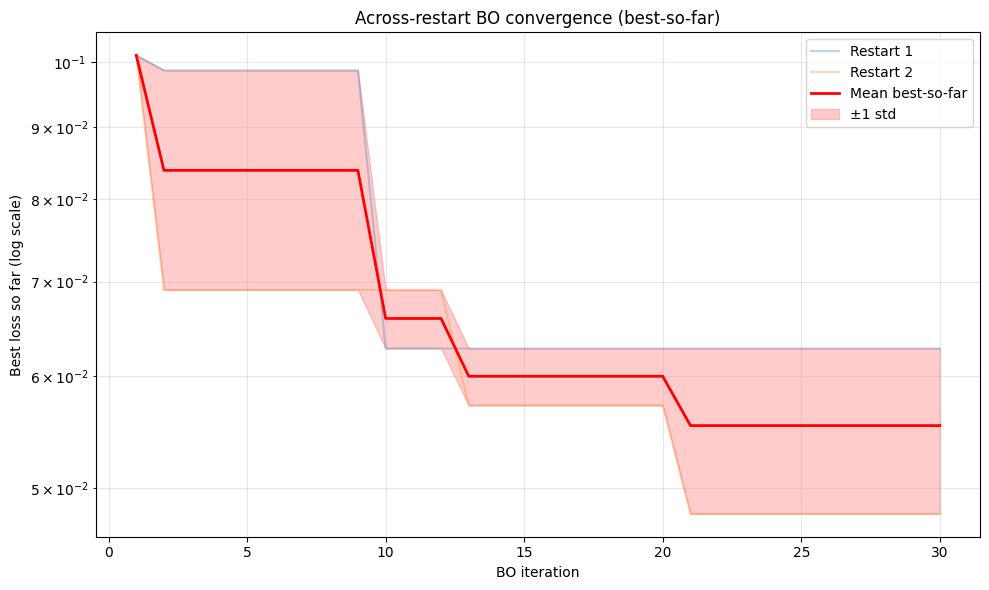

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Convert to array and compute best-so-far for each restart
trajectories = [np.minimum.accumulate(np.array(traj)) for traj in all_best_traj]
trajectories = np.array(trajectories)   # shape: (n_restarts, n_iters)

n_restarts, n_iters = trajectories.shape
iters = np.arange(1, n_iters + 1)

plt.figure(figsize=(10, 6))

# Plot each restart
for r in range(n_restarts):
    plt.plot(iters, trajectories[r], alpha=0.3, label=f"Restart {r+1}")

# Mean + std band
mean_curve = trajectories.mean(axis=0)
std_curve  = trajectories.std(axis=0)

plt.plot(iters, mean_curve, color="red", linewidth=2, label="Mean best-so-far")
plt.fill_between(
    iters,
    mean_curve - std_curve,
    mean_curve + std_curve,
    color="red", alpha=0.2, label="±1 std"
)

# Log scale
plt.yscale("log")

plt.xlabel("BO iteration")
plt.ylabel("Best loss so far (log scale)")
plt.title("Across-restart BO convergence (best-so-far)")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
# Identify the best restart
best_restart = int(np.argmin(all_final_best))
print("Best restart index:", best_restart)

# Best restart trajectory (best-so-far)
best_restart_traj = all_best_traj[best_restart]
best_restart_traj = np.minimum.accumulate(best_restart_traj)

# Print losses
print("\n=== Best Restart: Best-So-Far Loss Per Iteration ===\n")
for it, loss_val in enumerate(best_restart_traj):
    print(f"Iteration {it}: {loss_val:.6f}")

Best restart index: 1

=== Best Restart: Best-So-Far Loss Per Iteration ===

Iteration 0: 0.101138
Iteration 1: 0.069057
Iteration 2: 0.069057
Iteration 3: 0.069057
Iteration 4: 0.069057
Iteration 5: 0.069057
Iteration 6: 0.069057
Iteration 7: 0.069057
Iteration 8: 0.069057
Iteration 9: 0.069057
Iteration 10: 0.069057
Iteration 11: 0.069057
Iteration 12: 0.057225
Iteration 13: 0.057225
Iteration 14: 0.057225
Iteration 15: 0.057225
Iteration 16: 0.057225
Iteration 17: 0.057225
Iteration 18: 0.057225
Iteration 19: 0.057225
Iteration 20: 0.047979
Iteration 21: 0.047979
Iteration 22: 0.047979
Iteration 23: 0.047979
Iteration 24: 0.047979
Iteration 25: 0.047979
Iteration 26: 0.047979
Iteration 27: 0.047979
Iteration 28: 0.047979
Iteration 29: 0.047979


In [32]:
df_best = pd.read_csv(f"{config['simulation_run_path']}/BO/restart{best_restart}_full_training.csv")

best_iter = int(df_best['loss'].idxmin())
row = df_best.loc[best_iter]
best_bo_iteration = int(row['bo_iteration'])
print("Best iteration:", best_bo_iteration)

Best iteration: 30


In [33]:
prefix_output_bo = f"{simulation_run_path_BO}/restart{r}_iter{i}_batch{j}"
sim_edge_out = f"{prefix_output_bo}_{config['EDGE_OUT_STR']}"

In [34]:
# We assume batch=0 because BATCH_SIZE=1
best_sim_prefix = (
    f"{config['simulation_run_path']}/BO/"
    f"restart{best_restart}_iter{best_bo_iteration-1}_batch0"
)

best_sim_file = f"{best_sim_prefix}_{config['EDGE_OUT_STR']}"

print("Sim file:", best_sim_file)

Sim file: output/network_2corridor_bo_vanilla/BO/restart1_iter29_batch0_edge_data.xml


In [35]:
df_sim_best, _, _ = parse_loop_data_xml_to_pandas(
    base_path,
    best_sim_file,
    best_sim_prefix,
    config["SUMO_PATH"]
)

# NRMSE SCALE 

In [36]:
def compute_nrmse_counts_all_edges_Original(df_true, df_simulated):
    # Merge simulated output with ground truth
    df1 = df_true.merge(
        df_simulated,
        on=['edge_id'],
        suffixes=('_GT', '_sim'),
        how='left'
    )
    
    df1['interval_nVehContrib_sim'] = df1['interval_nVehContrib_sim'].fillna(0)
    
    df1['diff_square'] = (
        df1['interval_nVehContrib_GT'] - df1['interval_nVehContrib_sim']
    )**2
    
    n = len(df1)

    # Numerator: sqrt( (1/n) * sum(diff^2) )
    rmse = np.sqrt(df1['diff_square'].sum() / n)

    # Denominator: (1/n) * sum(GT)
    mean_gt = df1['interval_nVehContrib_GT'].sum() / n

    nrmse = rmse / mean_gt
    return nrmse

In [37]:
nrmse_best = compute_nrmse_counts_all_edges_Original(
    gt_edge_data,
    df_sim_best
)
print("NRMSE of best iteration:", nrmse_best)

NRMSE of best iteration: 0.11273994105317861


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Identify best restart
best_restart = int(np.argmin(all_final_best))
print("Best restart:", best_restart)

# 2) Load initial search data to find best initial point
df_0 = pd.read_csv(
    f"{config['simulation_run_path']}/initial_search/data_set_ods_0_2000.csv"
)

# Find the best initial search point (lowest loss/NRMSE)
best_initial_idx = df_0['loss'].idxmin()
best_initial_nrmse = df_0.loc[best_initial_idx, 'loss']
best_initial_sample_idx = df_0.loc[best_initial_idx, 'init_search'] if 'init_search' in df_0.columns else best_initial_idx
print(f"Best initial search point: sobol_{int(best_initial_sample_idx)} (index {int(best_initial_idx)} out of {len(df_0)} initial points)")
print(f"Best initial search point NRMSE: {best_initial_nrmse:.6f}")

# 3) Load best restart's full training DF
df_best = pd.read_csv(
    f"{config['simulation_run_path']}/BO/restart{best_restart}_full_training.csv"
)

# 4) Extract NRMSE (loss) values from df_best for each BO iteration (limit to first 30)
n_iters = min(df_best['bo_iteration'].max(), 30)  # Limit to 30 BO iterations
nrmse_curve_bo = []

for it in range(1, n_iters + 1):
    # Get all samples from this BO iteration
    df_it = df_best[df_best['bo_iteration'] == it]
    if df_it.empty:
        print(f"Warning: No data for BO iteration {it}")
        continue
    
    # Get the best (minimum) loss for this iteration
    best_loss_it = df_it['loss'].min()
    nrmse_curve_bo.append(best_loss_it)
    
    print(f"BO Iteration {it}: NRMSE = {best_loss_it:.6f}")

# 5) Combine: [best_initial] + BO iterations (total: 31 points from 0 to 30)
nrmse_curve = [best_initial_nrmse] + nrmse_curve_bo
print(f"\nFull NRMSE curve length: {len(nrmse_curve)} (best initial + {len(nrmse_curve_bo)} BO iterations)")

Best restart: 1
Best initial search point: sobol_14 (index 14 out of 20 initial points)
Best initial search point NRMSE: 0.101138
BO Iteration 1: NRMSE = 0.069057
BO Iteration 2: NRMSE = 0.201176
BO Iteration 3: NRMSE = 0.116534
BO Iteration 4: NRMSE = 0.162204
BO Iteration 5: NRMSE = 0.195103
BO Iteration 6: NRMSE = 0.125944
BO Iteration 7: NRMSE = 0.072926
BO Iteration 8: NRMSE = 2.274313
BO Iteration 9: NRMSE = 0.140114
BO Iteration 10: NRMSE = 0.259996
BO Iteration 11: NRMSE = 0.076130
BO Iteration 12: NRMSE = 0.057225
BO Iteration 13: NRMSE = 0.185258
BO Iteration 14: NRMSE = 0.225852
BO Iteration 15: NRMSE = 0.252261
BO Iteration 16: NRMSE = 0.192615
BO Iteration 17: NRMSE = 0.104139
BO Iteration 18: NRMSE = 0.102759
BO Iteration 19: NRMSE = 0.058993
BO Iteration 20: NRMSE = 0.047979
BO Iteration 21: NRMSE = 0.309217
BO Iteration 22: NRMSE = 0.093066
BO Iteration 23: NRMSE = 0.122144
BO Iteration 24: NRMSE = 0.074728
BO Iteration 25: NRMSE = 0.183791
BO Iteration 26: NRMSE = 0.05

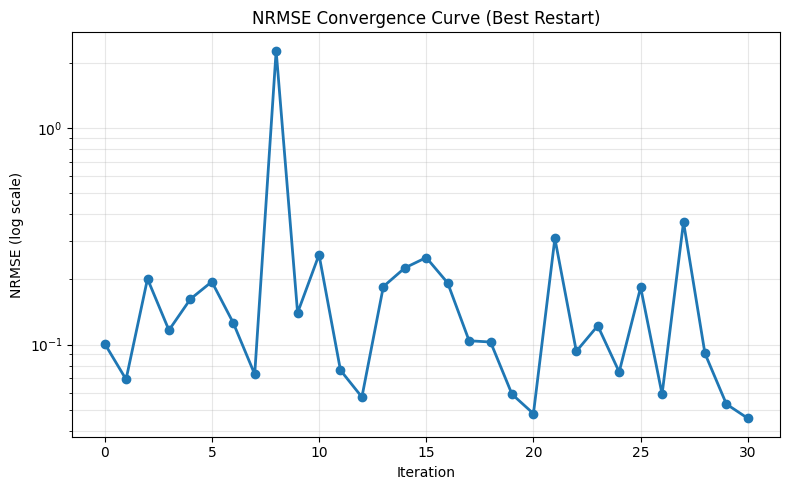

In [45]:
import matplotlib.pyplot as plt
import numpy as np

iters = np.arange(0, len(nrmse_curve))  # Start from 0 (best initial point)

plt.figure(figsize=(8,5))
plt.plot(iters, nrmse_curve, marker='o', linewidth=2)

plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("NRMSE (log scale)")
plt.title("NRMSE Convergence Curve (Best Restart)")
plt.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()

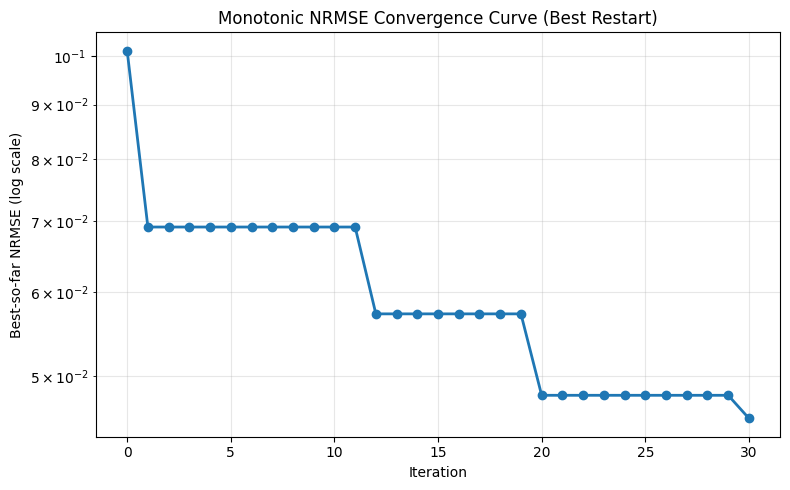

In [46]:
best_so_far_nrmse = np.minimum.accumulate(nrmse_curve)

iters = np.arange(0, len(best_so_far_nrmse))  # Start from 0 (best initial point)
plt.figure(figsize=(8,5))
plt.plot(iters, best_so_far_nrmse, marker='o', linewidth=2)

plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Best-so-far NRMSE (log scale)")
plt.title("Monotonic NRMSE Convergence Curve (Best Restart)")
plt.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()

In [27]:
print (best_so_far_nrmse)

[0.10113846 0.10113846 0.10113846 0.10113846 0.10113846 0.10113846
 0.10113846 0.10113846 0.10113846 0.10113846 0.10113846 0.10113846
 0.10113846 0.10113846 0.10113846 0.10113846 0.10113846 0.10113846
 0.10113846 0.10113846 0.10113846 0.10113846 0.10113846 0.10113846
 0.10113846 0.10113846 0.10113846 0.10113846 0.10113846 0.10113846
 0.10113846]


Best restart: 1
Best iteration: 30
NRMSE (best iteration): 0.11273994105317861


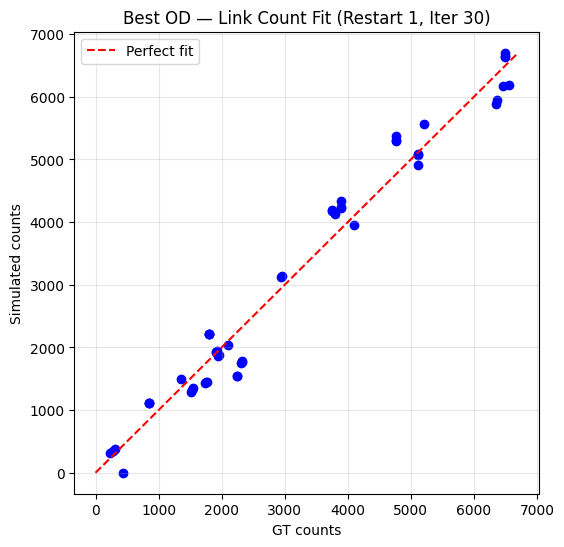

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================
#       1) Identify best restart
# ============================================

best_restart = int(np.argmin(all_final_best))
print("Best restart:", best_restart)

# df_best loaded earlier (from your convergence loop)

n_iters = df_best["bo_iteration"].max()

# ============================================
#       2) Recompute NRMSE curve exactly as before
# ============================================

nrmse_curve = []

for it in range(1, n_iters + 1):
    sim_prefix = (
        f"{config['simulation_run_path']}/BO/"
        f"restart{best_restart}_iter{it-1}_batch0"
    )
    sim_file = f"{sim_prefix}_{config['EDGE_OUT_STR']}"

    df_sim, _, _ = parse_loop_data_xml_to_pandas(
        base_path,
        sim_file,
        sim_prefix,
        config["SUMO_PATH"]
    )

    nrmse_it = compute_nrmse_counts_all_edges_Original(
        gt_edge_data,
        df_sim
    )
    nrmse_curve.append(nrmse_it)

nrmse_curve = np.array(nrmse_curve)

# Identify best iteration of this restart
best_iter = int(np.argmin(nrmse_curve)) + 1
print("Best iteration:", best_iter)

# ============================================
#       3) Load simulated edges for best iter
# ============================================

sim_prefix = (
    f"{config['simulation_run_path']}/BO/"
    f"restart{best_restart}_iter{best_iter-1}_batch0"
)
sim_file = f"{sim_prefix}_{config['EDGE_OUT_STR']}"

df_sim_best, _, _ = parse_loop_data_xml_to_pandas(
    base_path,
    sim_file,
    sim_prefix,
    config["SUMO_PATH"]
)

# ============================================
#       4) Compute NRMSE for best iteration
# ============================================

nrmse_best = compute_nrmse_counts_all_edges_Original(
    gt_edge_data,
    df_sim_best
)

print("NRMSE (best iteration):", nrmse_best)

# ============================================
#       5) GT vs Sim scatter plot
# ============================================

df_plot = gt_edge_data.merge(
    df_sim_best,
    on="edge_id",
    how="left",
    suffixes=("_gt", "_sim")
)

gt = df_plot["interval_nVehContrib_gt"].values
sim = df_plot["interval_nVehContrib_sim"].fillna(0).values

plt.figure(figsize=(6,6))
maxv = max(gt.max(), sim.max())
plt.plot([0, maxv], [0, maxv], "r--", label="Perfect fit")
plt.scatter(gt, sim, color="blue")

plt.xlabel("GT counts")
plt.ylabel("Simulated counts")
plt.title(f"Best OD — Link Count Fit (Restart {best_restart}, Iter {best_iter})")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [ ]:
# 1. Load the best restart training DF
df_best = pd.read_csv(
    f"{config['simulation_run_path']}/BO/restart{best_restart}_full_training.csv"
)

# 2. Extract BEST row according to NRMSE/loss
idx_best_row = int(df_best["loss"].idxmin())
best_row = df_best.loc[idx_best_row]

# 3. Extract OD vector
best_X_real = best_row[[col for col in df_best.columns if col.startswith("x_")]].to_numpy()

print("Best OD:", best_X_real)

Best OD: [1633.89113584    0.         2000.         2000.         1897.3076063
    0.         1943.78149054  424.55260096    0.         2000.
 1028.98433183    0.          627.1521347  1064.31550161 1623.3034795
  681.49310916 2000.         2000.         1138.85863665 1589.41912788
 1111.86145358]


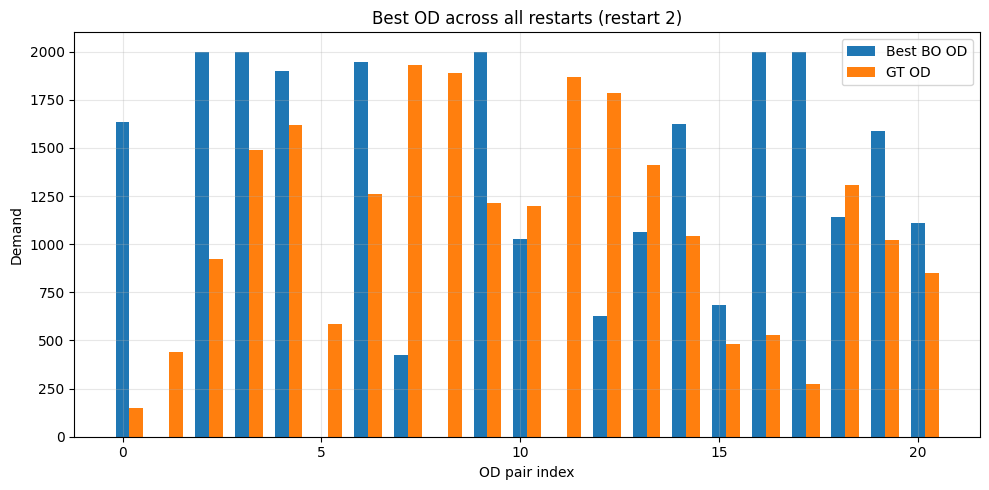

In [ ]:
plt.figure(figsize=(10, 5))
idx = np.arange(len(best_X_real))
width = 0.35

plt.bar(idx, best_X_real, width, label="Best BO OD")
plt.bar(idx + width, gt_od_vals, width, label="GT OD")

plt.xlabel("OD pair index")
plt.ylabel("Demand")
plt.title(f"Best OD across all restarts (restart {best_restart+1})")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
#print(df_0)

In [ ]:
#print(df_training)

Store outputs

In [ ]:
print(f"saving at {config['simulation_run_path']}/BO/data_set_bayes_opt.csv")
df_training.to_csv(f"{config['simulation_run_path']}/BO/data_set_bayes_opt.csv",index=None)

print(f"saving at {config['simulation_run_path']}/BO/df_edge_stats.csv")
df_edge_stats.to_csv(f"{config['simulation_run_path']}/BO/df_edge_stats.csv",index=None)

saving at output/network_2corridor_bo_vanilla/BO/data_set_bayes_opt.csv
saving at output/network_2corridor_bo_vanilla/BO/df_edge_stats.csv


# Results analysis

Convergence plots

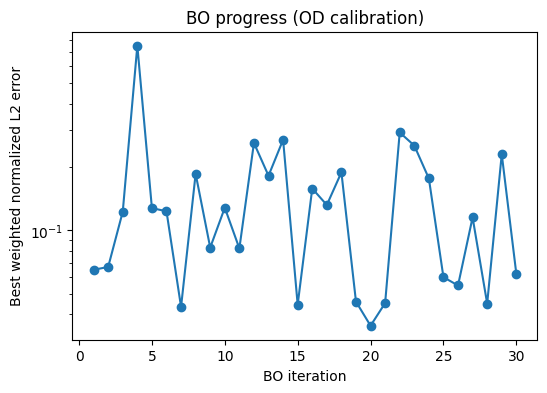

In [ ]:
df_training = pd.read_csv(f"{config['simulation_run_path']}/BO/data_set_bayes_opt.csv")
df_edge_stats = pd.read_csv(f"{config['simulation_run_path']}/BO/df_edge_stats.csv")



df_plot = df_training.query('bo_iteration>0')
x = df_plot['bo_iteration']
y = df_plot['loss']


plt.figure(figsize=(6, 4))
plt.plot(x, y, marker="o")

plt.xlabel("BO iteration")
plt.ylabel("Best weighted normalized L2 error")  # <-- fixed label
plt.title("BO progress (OD calibration)")

# Optional: log scale because values are ~1e-5
plt.yscale("log")


In [ ]:
if df_edge_stats.batch.drop_duplicates().shape[0] > 1:
    raise('This needs updating once we start using batches')

losses = []
for o1 in range(config["NITER"]): #num_epsilon_iter):
    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)
    losses.append(curr_loss)

Scatter plots: fit to traffic data

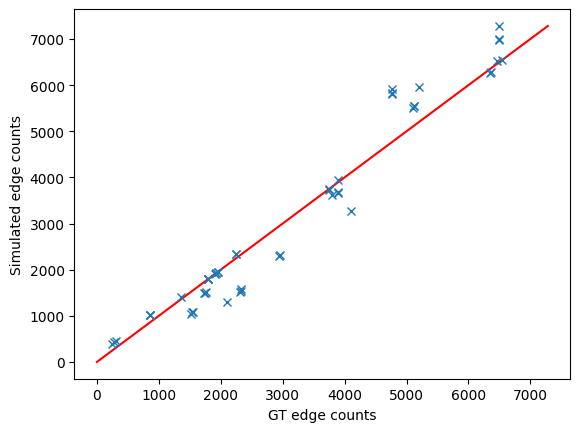

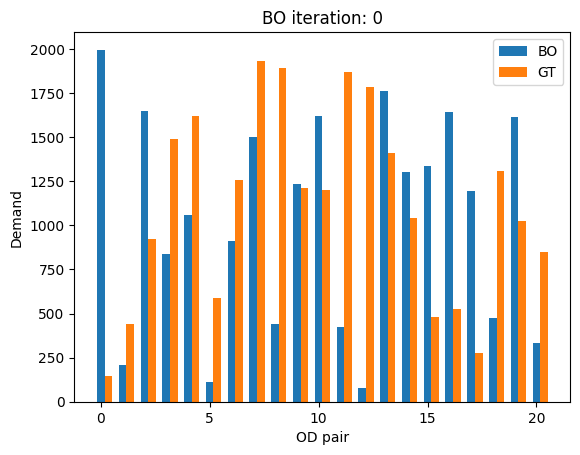

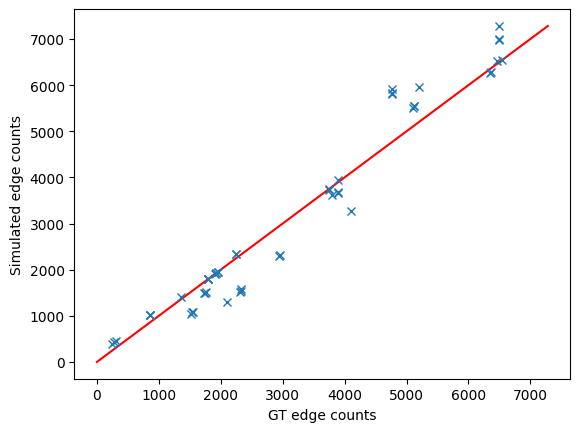

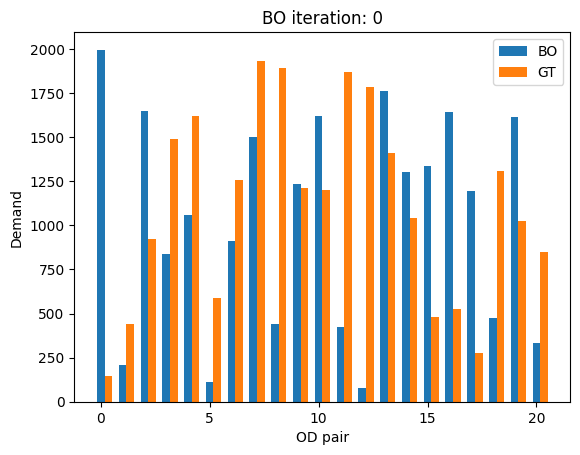

In [ ]:
if df_edge_stats.batch.drop_duplicates().shape[0] > 1:
    raise('This needs updating once we start using batches')

Path(f"{config['simulation_run_path']}/figs").mkdir(parents=True, exist_ok=True)

losses = []
for o1 in range(2): #num_epsilon_iter):
    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss =compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)
    losses.append(curr_loss)

    # find idx of min loss
    idx_min = np.argmin(losses)
    o1 = idx_min

    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)

    plt.figure()
    # plotting diagonal line that represents a perfect data fit
    max_val = np.max([df1b.interval_nVehContrib_gt.max(), df1b.interval_nVehContrib_bo.max()])
    vec = np.arange(max_val)
    plt.plot(vec, vec, 'r-')
    plt.plot(df1b.interval_nVehContrib_gt, df1b.interval_nVehContrib_bo, 'x')
    # plt.title(f'BO epochs: {o1}; loss: {curr_loss}')
    plt.xlabel('GT edge counts')
    plt.ylabel('Simulated edge counts')
    #plt.savefig(f"{config['simulation_run_path']}/figs/{o1}_bo_edge_counts.png")


    # plot of fit to GT OD vs ET OD
    plt.figure()
    # get the OD values with the best loss
    curr_od = df_training.query('bo_iteration==@o1').iloc[0][[col for col in df_training.columns if "x" in col]].values
    # bar graph side by side by x axis
    width = 0.35
    plt.bar(np.arange(len(curr_od)), curr_od, width, label='BO')
    plt.bar(np.arange(len(gt_od_vals)) + width, gt_od_vals, width, label='GT')
    plt.legend()
    plt.xlabel('OD pair')
    plt.ylabel('Demand')
    plt.title(f'BO iteration: {o1}')
    # plt.savefig(f"{config['simulation_run_path']}/figs/{o1}_bo_od.png")

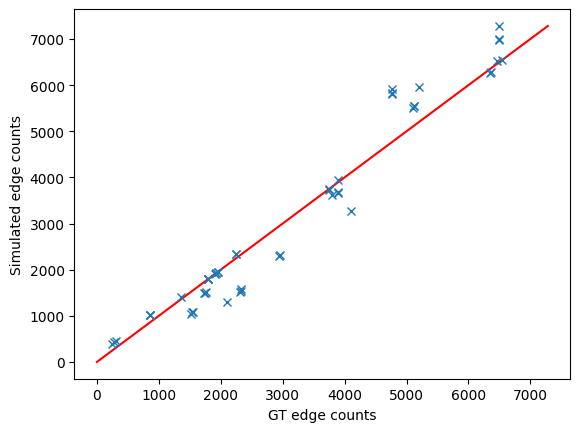

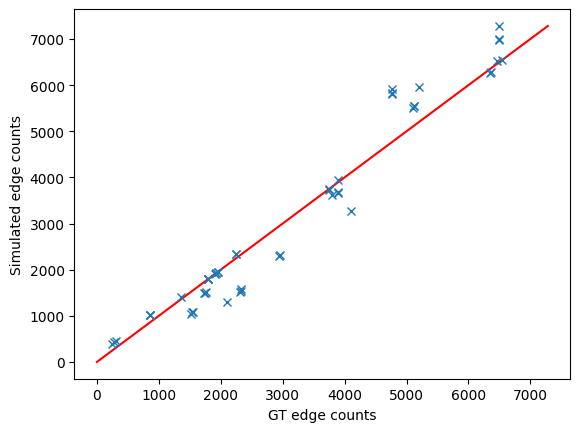

In [ ]:
if df_edge_stats.batch.drop_duplicates().shape[0] > 1:
    raise('This needs updating once we start using batches')

Path(f"{config['simulation_run_path']}/figs").mkdir(parents=True, exist_ok=True)

losses = []
for o1 in range(2): #num_epsilon_iter):
    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)
    losses.append(curr_loss)

    # find idx of min loss
    idx_min = np.argmin(losses)
    o1 = idx_min

    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)

    plt.figure()
    # plotting diagonal line that represents a perfect data fit
    max_val = np.max([df1b.interval_nVehContrib_gt.max(), df1b.interval_nVehContrib_bo.max()])
    vec = np.arange(max_val)
    plt.plot(vec, vec, 'r-')
    plt.plot(df1b.interval_nVehContrib_gt, df1b.interval_nVehContrib_bo, 'x')
    # plt.title(f'BO epochs: {o1}; loss: {curr_loss}')
    plt.xlabel('GT edge counts')
    plt.ylabel('Simulated edge counts')
    #plt.savefig(f"{config['simulation_run_path']}/figs/{o1}_bo_edge_counts.png")

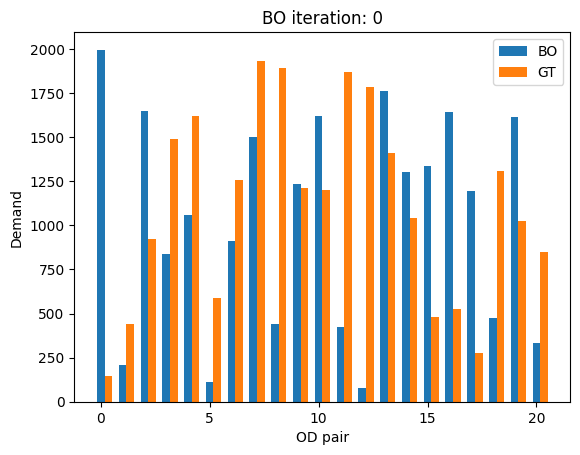

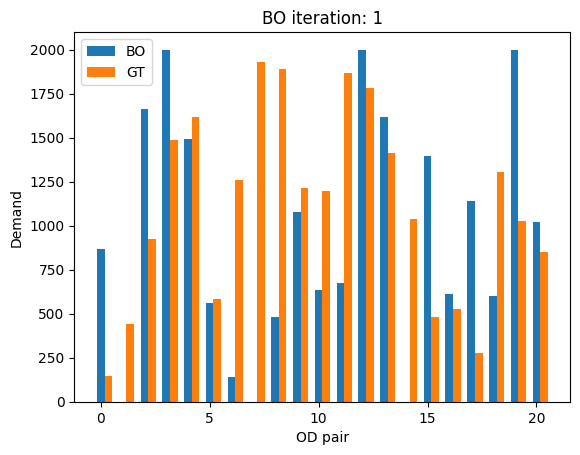

In [ ]:
# disable interactive mode
#plt.ioff()
%matplotlib inline

if df_edge_stats.batch.drop_duplicates().shape[0] > 1:
    raise('This needs updating once we start using batches')

Path(f"{config['simulation_run_path']}/figs").mkdir(parents=True, exist_ok=True)

losses = []
for o1 in range(2): #num_epsilon_iter):
    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)
    losses.append(curr_loss)

    # find idx of min loss
    idx_min = np.argmin(losses)
    o1 = idx_min

    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    df1b = gt_edge_data.merge(curr_edge_stats, on=['edge_id'], how='left', suffixes=('_gt', '_bo'))
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)

    # plot of fit to GT OD vs ET OD
    plt.figure()
    # get the OD values with the best loss
    curr_od = df_training.query('bo_iteration==@o1').iloc[0][[col for col in df_training.columns if "x" in col]].values
    # bar graph side by side by x axis
    width = 0.35
    plt.bar(np.arange(len(curr_od)), curr_od, width, label='BO')
    plt.bar(np.arange(len(gt_od_vals)) + width, gt_od_vals, width, label='GT')
    plt.legend()
    plt.xlabel('OD pair')
    plt.ylabel('Demand')
    plt.title(f'BO iteration: {o1}')
    # plt.savefig(f"{config['simulation_run_path']}/figs/{o1}_bo_od.png")

In [ ]:
# Columns corresponding to OD entries
od_cols = [c for c in df_training.columns if c.startswith("x_")]

# All OD vectors + loss, ordered by iteration
df_ods_all = df_training[["bo_iteration"] + od_cols + ["loss"]].sort_values(
    by=["bo_iteration"]
)

print("=== All tested ODs (initial design + BO) ===")
print(df_ods_all.to_string(index=False))

=== All tested ODs (initial design + BO) ===
 bo_iteration         x_1         x_2         x_3         x_4         x_5         x_6         x_7         x_8         x_9        x_10        x_11        x_12        x_13        x_14        x_15        x_16        x_17        x_18        x_19        x_20        x_21     loss
            0 1995.026708  208.732784 1645.957708  838.864326 1056.644201  112.481415  910.584569 1498.406053  442.148268 1235.396743 1620.189548  424.581140   76.872244 1763.648033 1301.259279 1333.170295 1641.863227 1193.157077  472.615093 1613.948703  334.287435 0.128261
            0  922.826648  441.071898 1875.242472 1775.418758   28.165109  381.016970 1930.124760 1280.058980 1132.409096  995.675087  849.851131 1591.199875 1801.116109   62.975183  319.015712 1804.525495 1689.627171  941.004395  380.762577 1073.835731 1657.146931 2.766865
            0  187.231794 1502.625465  857.192457  606.478155  759.049952  512.261987  963.756859 1734.253645 1636.089563  210.972

In [ ]:
df_ods_bo = df_training.loc[df_training["bo_iteration"] > 0,
                            ["bo_iteration"] + od_cols + ["loss"]].sort_values(
    by=["bo_iteration"]
)

print("=== ODs tested during BO only ===")
print(df_ods_bo.to_string(index=False))

=== ODs tested during BO only ===
 bo_iteration         x_1         x_2         x_3         x_4         x_5         x_6         x_7         x_8         x_9        x_10        x_11        x_12        x_13        x_14        x_15        x_16        x_17        x_18        x_19        x_20        x_21     loss
            1  865.615762    0.000000 1661.739428 2000.000000 1495.234300  563.354214  137.991127    0.000000  479.213761 1076.604528  632.956623  674.136339 2000.000000 1616.002949    0.000000 1397.567338  613.084819 1142.786987  603.228488 2000.000000 1020.149342 0.098684
            2    0.000000    0.000000  915.703156 2000.000000 1240.812725 1639.607305  527.521309 1205.422409    0.000000 1608.231984 2000.000000 2000.000000  127.887753  100.840522    0.000000    0.204630  457.498445    0.000000    0.000000 1843.804506  985.102210 0.070592
            3  550.776758    0.000000 1393.470050 2000.000000 2000.000000 1334.126670  992.117927  668.109190    0.000000 2000.000000 2000.00

In [ ]:
edge_cols = ["bo_iteration", "batch", "edge_id", "interval_nVehContrib"]

df_edges_view = df_edge_stats[edge_cols].sort_values(
    by=["bo_iteration", "batch", "edge_id"]
)

print("=== Edge flows per BO iteration ===")
print(df_edges_view.to_string(index=False))

=== Edge flows per BO iteration ===
 bo_iteration  batch                    edge_id  interval_nVehContrib
            0      0                   11531386                  2348
            0      0                  394165856                  1959
            0      0                  394165857                  1020
            0      0                  394170678                  1919
            0      0                394170681#0                  1916
            0      0                  395318356                  3275
            0      0                  395358019                   433
            0      0                416220210#0                  2346
            0      0                  417524818                  1925
            0      0                  456092814                  1519
            0      0                456092817#0                  1529
            0      0                  479773094                  3944
            0      0                  479773095       

Best iteration = 19
Best loss      = 0.035333


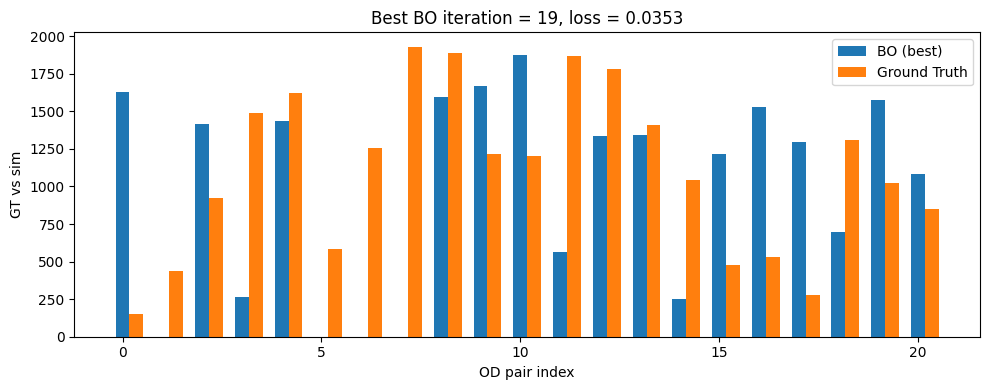

In [ ]:
# disable interactive mode
%matplotlib inline

Path(f"{config['simulation_run_path']}/figs").mkdir(parents=True, exist_ok=True)

# --------------------------------------------------
# 1) Compute losses for all iterations
# --------------------------------------------------
losses = []

for o1 in range(20):
    curr_edge_stats = df_edge_stats[df_edge_stats.bo_iteration == o1]
    if curr_edge_stats.empty:
        continue  # iteration didn't run yet

    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_edge_stats)
    losses.append(curr_loss)

# --------------------------------------------------
# 2) Identify the best iteration
# --------------------------------------------------
best_iter = int(np.argmin(losses))
best_loss = losses[best_iter]

print(f"Best iteration = {best_iter}")
print(f"Best loss      = {best_loss:.6f}")

# --------------------------------------------------
# 3) Retrieve OD values for the best iteration
# --------------------------------------------------
curr_od = df_training.query("bo_iteration == @best_iter").iloc[0][
    [col for col in df_training.columns if "x" in col]
].values

# --------------------------------------------------
# 4) Plot BO OD vs GT OD for the best iteration only
# --------------------------------------------------
plt.figure(figsize=(10,4))

width = 0.35
x_axis = np.arange(len(curr_od))

plt.bar(x_axis, curr_od, width, label='BO (best)')
plt.bar(x_axis + width, gt_od_vals, width, label='Ground Truth')

plt.legend()
plt.xlabel("OD pair index")
plt.ylabel("GT vs sim")
plt.title(f"Best BO iteration = {best_iter}, loss = {best_loss:.4f}")

plt.tight_layout()
plt.savefig(f"{config['simulation_run_path']}/figs/best_iteration_od.png")

plt.show()

In [ ]:
print (losses)

[0.09868412308076412, 0.07059211167715466, 0.1243161909355309, 0.15600243081342244, 0.3764184117592071, 0.2152355809244339, 0.23291569842779866, 0.2812023211765216, 0.2151965428907328, 1.816487465211481, 0.05638066214501222, 0.24817227937027717, 0.10615616855718635, 0.2630817117528797, 0.19145190718858765, 0.04100419756476845, 0.3114593281918285, 0.1461422984011176, 0.14057897357485388, 0.7801551141263937]


In [ ]:
def compute_nrmse_counts_all_edges_original(df_true, df_sim):
    # Merge simulated output with ground truth
    df1 = df_true.merge(df_sim, on="edge_id", suffixes=("_GT", "_sim"), how="left")
    df1["interval_nVehContrib_sim"] = df1["interval_nVehContrib_sim"].fillna(0)

    df1["diff_square"] = (df1["interval_nVehContrib_GT"] - df1["interval_nVehContrib_sim"]) ** 2

    numerator = np.sqrt(df1["diff_square"].sum() / len(df1))
    denominator = df1["interval_nVehContrib_GT"].mean()

    return numerator / denominator

In [ ]:
def compute_nrmse_per_iteration(df_edge_stats, df_gt, NITER):
    nrmse_list = []
    for it in range(20):
        df_sim = df_edge_stats[df_edge_stats.bo_iteration == it]
        curr_nrmse = compute_nrmse_counts_all_edges_original(df_gt, df_sim)
        nrmse_list.append(curr_nrmse)
    return np.array(nrmse_list)

In [ ]:
def compute_best_so_far_nrmse(nrmse_curve):
    return np.minimum.accumulate(nrmse_curve)

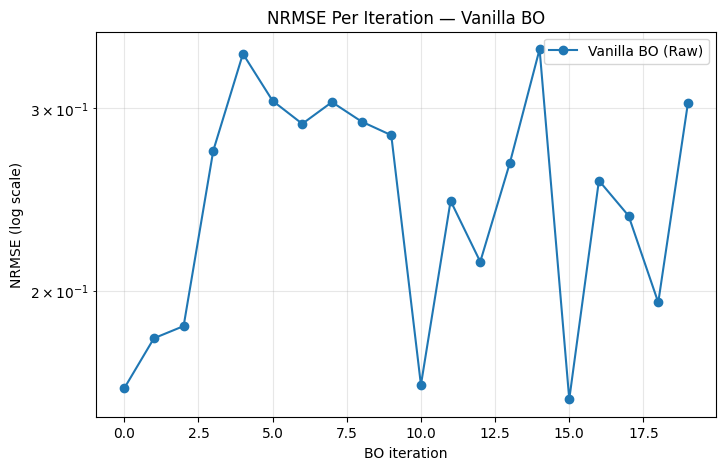

In [ ]:
nrmse_raw = compute_nrmse_per_iteration(df_edge_stats, gt_edge_data, 10)

plt.figure(figsize=(8,5))
plt.plot(range(len(nrmse_raw)), nrmse_raw, marker='o', label="Vanilla BO (Raw)")
plt.yscale("log")
plt.xlabel("BO iteration")
plt.ylabel("NRMSE (log scale)")
plt.title("NRMSE Per Iteration — Vanilla BO")
plt.grid(True, which="both", alpha=0.3)
plt.legend()

save_path = Path(f"{config['simulation_run_path']}/figs/vanilla_nrmse_raw.png")
plt.savefig(save_path, dpi=300)
plt.show()

In [ ]:
print (nrmse_raw)

[0.16115998 0.18007099 0.18499791 0.27309229 0.33859579 0.30503402
 0.28985544 0.30416568 0.29129315 0.28262188 0.16235627 0.24429373
 0.21338799 0.26586253 0.34204973 0.15727752 0.25555119 0.23631733
 0.19497105 0.3034353 ]
